## init Keras

In [46]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [47]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import seaborn as sns
from scipy.io import loadmat
from scipy.io import savemat
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style 
import os
import pandas as pd

reparameterization trick<br>
instead of sampling from Q(z|X), sample epsilon = N(0,I)<br>
z = z_mean + sqrt(var) * epsilon

### Some helper Funcs

In [48]:
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [49]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the FC classes in the latent space
    cmap = {0: 'CNT', 1: 'UWS', 2: 'MCS'}
    colors = ['blue', 'green', 'red']

    # display a 2D plot of the FC classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    
    n = 10
    digit_size = 90
    n_x = 16
    n_y = 8
    figure = np.zeros((digit_size * n_y, digit_size * n_x))
    # linearly spaced coordinates corresponding to the 2D plot
    # of FC classes in the latent space
    grid_x = np.linspace(-6, 2, n_x)
    grid_y = np.linspace(1, 4, n_y)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(15, 10))
    start_range = digit_size // 2
    end_range_x = (n_x - 1) * digit_size + start_range + 1
    pixel_range_x = np.arange(start_range, end_range_x, digit_size)
    start_range = digit_size // 2
    end_range_y = (n_y - 1) * digit_size + start_range + 1
    pixel_range_y = np.arange(start_range, end_range_y, digit_size)

    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    #plt.xticks(pixel_range_x, sample_range_x)
    #plt.yticks(pixel_range_y, sample_range_y)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("z$_0$", fontsize=18)
    plt.ylabel("z$_1$", fontsize=18)

    plt.imshow(figure) #cmap='Greys_r')
    plt.grid(color='w', linewidth=2)
    plt.title("Grid sampling of Latent Space", fontsize=18)
        # Add fine white lines to separate the grid
    for i in range(1, n_y):
        plt.axhline(i * digit_size - 0.5, color='white', linewidth=0.5)
    for j in range(1, n_x):
        plt.axvline(j * digit_size - 0.5, color='white', linewidth=0.5)

    #plt.savefig(filename)

    plt.show()
# MNIST dataset



In [50]:
def plot_results2(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the FC classes in the latent space
    cmap = {0: 'CNT', 1: 'UWS', 2: 'MCS'}
    colors = ['blue', 'green', 'red']

    # display a 2D plot of the FC classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    for i in range(3):
        plt.scatter(z_mean[y_test==i, 0], z_mean[y_test==i, 1], color=colors[i], label=cmap[i])
    plt.legend()
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.savefig(filename)
    plt.show()
    filename = os.path.join(model_name, "FCs_over_latent.png")
    # display a 30x30 2D manifold of FCs
    
    n = 10
    digit_size = 90
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of FC classes in the latent space
    grid_x = np.linspace(-6, 2, 32)
    grid_y = np.linspace(1, 4, 16)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(15, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure) #cmap='Greys_r')
    plt.grid(color='w', linewidth=2)
    #plt.savefig(filename)
    plt.show()
# MNIST dataset


def calc_cohensd(x,y):
    d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
    print(f"Cohens d =:{d}")
    return d


In [51]:
import numpy as np

def calculate_distance_along_line(starting_point, end_point, data_points):
    # Step 1: Calculate line vector
    line_vector = end_point - starting_point
    # Step 2: Normalize line vector
    line_direction = line_vector / np.linalg.norm(line_vector)

    distances = []
    for point in data_points:
        # Step 3: Calculate displacement vector
        displacement_vector = point - starting_point
        # Step 4: Project displacement vector onto line direction
        distance_along_line = np.dot(displacement_vector, line_direction)
        distances.append(distance_along_line)
    #distances

    #return np.array(list(filter(lambda d: d>0,np.diff(distances))))  # If i only want the advancement 
    return np.diff(distances)


# Define exp variables

In [52]:
EXP_NAME = 'gusDMF_G159-175_CondVae' # "Updated3000gusDMF_cntmcsuws" # Updated is the name af the correction of code. The idx used in the paper was not saved, but the model was
ONLY_UWSMCS = False
WITH_PERTURB = False

## Load Data

In [54]:
NUM_SIM = 3000
CNT_data = np.zeros((NUM_SIM,90*90))
for rep in range(1,151):
    CNT_data[(rep-1)*20:rep*20,:]=np.reshape(loadmat(f"./Results/FCGeneration/G210_CNT/CNT_G210_{rep}.mat")["FC_simul2"],(20,8100))
MCS_data = np.zeros((NUM_SIM,90*90))
for rep in range(1,151):
    MCS_data[(rep-1)*20:rep*20,:]=np.reshape(loadmat(f"./Results/FCGeneration/G175_MCS/MCS_G175_{rep}.mat")["FC_simul2"],(20,8100))
UWS_data = np.zeros((NUM_SIM,90*90))
for rep in range(1,151):
    UWS_data[(rep-1)*20:rep*20,:]=np.reshape(loadmat(f"./Results/FCGeneration/G159_UWS/UWS_G159_{rep}.mat")["FC_simul2"],(20,8100))



if WITH_PERTURB:
    conditions = ['5HT2A', '5HT1A','D2', 'D1', 'CB1', 'H3', 'MU','DAT']
    UWSMCS_perturbs = np.zeros((len(conditions)*2, 101, 8100))
    for idx,cond in enumerate(conditions):
        perturb_fcs = loadmat(f"./Results/FC_{cond}_MCS.mat")["FC_simul_all"]
        UWSMCS_perturbs[idx, :, : ] = np.reshape(perturb_fcs[:101], (101, 8100))
    conditions = ['5HT2A', '5HT1A','D2', 'D1', 'CB1', 'H3', 'MU','DAT']
    for idx,cond in enumerate(conditions):
        perturb_fcs = loadmat(f"./Results/FC_{cond}_UWS.mat")["FC_simul_all"]
        UWSMCS_perturbs[idx+len(conditions), :, : ] = np.reshape(perturb_fcs[:101], (101, 8100))
    UWSMCS_perturbs = np.reshape(UWSMCS_perturbs, (UWSMCS_perturbs.shape[0]*UWSMCS_perturbs.shape[1], 8100))
    small_data = np.concatenate((CNT_data,UWS_data,MCS_data, UWSMCS_perturbs),axis=0)
    label = np.concatenate((np.zeros((NUM_SIM,)),np.ones((NUM_SIM,)),np.ones((NUM_SIM,))*2,np.ones((NUM_SIM,))*3),axis=0)
elif ONLY_UWSMCS: 
    small_data = np.concatenate((CNT_data,UWS_data),axis=0)
    label = np.concatenate((np.zeros((NUM_SIM,)),np.ones((NUM_SIM,))),axis=0)
else: # Classic with all
    small_data = np.concatenate((CNT_data,UWS_data,MCS_data),axis=0)
    label = np.concatenate((np.zeros((NUM_SIM,)),np.ones((NUM_SIM,)),np.ones((NUM_SIM,))*2),axis=0)
if not os.path.exists(f"models/{EXP_NAME}_idx.npy"):
    print("Generating random indexation")
    with open(f"models/{EXP_NAME}_idx.npy", 'wb') as f:
        idx = np.random.permutation(small_data.shape[0])
        np.save(f,idx)
else:
    print("Loading random indexation")
    with open(f"models/{EXP_NAME}_idx.npy", 'rb') as f:
        idx = np.load(f)
my_data, label_1 = small_data[idx,:],label[idx]
x_train = my_data[:int(len(my_data) * 0.6)]  # 60% for training
x_val = my_data[int(len(my_data) * 0.6):int(len(my_data) * 0.8)]  # 20% for validation
x_test = my_data[int(len(my_data) * 0.8):]  # 20% for testing

y_train = label_1[:int(len(my_data) * 0.6)]
y_val = label_1[int(len(my_data) * 0.6):int(len(my_data) * 0.8)]
y_test = label_1[int(len(my_data) * 0.8):]

Loading random indexation


## Create or Load model

In [55]:
from keras.layers import Dropout
from keras.layers.merge import concatenate as concat
model_name = EXP_NAME
experiment_name = EXP_NAME
original_dim = 8100 
intermediate_dim = 128
batch_size = 256
latent_dim = 2
epochs = 50
# Creating a conditional VAE we need to add the label in the input
input_shape = (original_dim, )
intput_label_shape = 1#y_train.shape[1]
inputs_x = Input(shape=input_shape, name='x_input')
inputs_label = Input(shape=(1,),name='label_input')
inputs = concat([inputs_x, inputs_label],axis=1)

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model([inputs_x,inputs_label], [z_mean, z_log_var, z], name='encoder')
#encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

latent_x = Input(shape=(latent_dim,), name='z_sampling')
latent_inputs = concat([latent_x, inputs_label])

x = Dense(intermediate_dim, activation='relu')(latent_inputs)
x = Dropout(0.8)(x)
outputs = Dense(original_dim+1, activation='sigmoid')(x)
decoder = Model([latent_x, inputs_label], outputs, name='decoder')
#decoder.summary()

#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

outputs = decoder([encoder([inputs_x, inputs_label])[2], inputs_label])
vae = Model([inputs_x,inputs_label], outputs, name=model_name)
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = binary_crossentropy(inputs,outputs)
                                                
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_input (InputLayer)            (None, 8100)         0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 1037572     x_input[0][0]                    
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
decoder (Model)                 (None, 8101)         1045541     encoder[1][2]                    
          

### Loading or training

In [56]:
TRAIN = False
if TRAIN:
        vae.fit([x_train,y_train],
                epochs=50,
                batch_size=batch_size,
                validation_data=([x_test,y_test], None))
        #vae.load_weights('vae_mlp_3d_mnist.h5')       
        vae.save_weights(f"models/{experiment_name}" + '.h5')
        #np.save(f"{model_name}_idx.npy",idx)
        # serialize model to JSON
        model_json = vae.to_json()
        with open(f"models/{experiment_name}"+".json", "w") as json_file:
                json_file.write(model_json)
else:
        print("Loading trained model")
        from keras.models import model_from_json
        model_name = EXP_NAME
        experiment_name = EXP_NAME
        with open(f"models/{experiment_name}.json",'r') as f:
                model_json = f.read()
        vae = model_from_json(model_json.encode())
        vae.load_weights(f"models/{experiment_name}.h5") 
        # TODO: IDx load

Loading trained model


# FIG 2 plots

## Stat diff between genererated FC


In [57]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr


MCS_fc_emp = loadmat(f"./Results/MCS_model_001.mat")['FC_emp']
CNT_fc_emp = loadmat(f"./Results/CNT_model_001.mat")['FC_emp']
UWS_fc_emp = loadmat(f"./Results/UWS_model_001.mat")['FC_emp']


CNT_data = np.zeros((150,90,90))
for rep in range(1,151):
    CNT_data[rep-1,:,:]=np.mean(loadmat(f"./Results/FCGeneration/G210_CNT/CNT_G210_{rep}.mat")["FC_simul2"][:13], axis=0)
MCS_data = np.zeros((150,90,90))
for rep in range(1,151):
    MCS_data[rep-1,:,:]=np.mean(loadmat(f"./Results/FCGeneration/G175_MCS/MCS_G175_{rep}.mat")["FC_simul2"][:11], axis=0)
UWS_data = np.zeros((150,90,90))
for rep in range(1,151):
    UWS_data[rep-1,:,:]=np.mean(loadmat(f"./Results/FCGeneration/G159_UWS/UWS_G159_{rep}.mat")["FC_simul2"][:10], axis=0)



conditions = ['UWS', 'MCS', 'CNT']
data = {'UWS':UWS_data, 'MCS':MCS_data, 'CNT':CNT_data}
fc_emp = {'UWS':UWS_fc_emp, 'MCS':MCS_fc_emp, 'CNT':CNT_fc_emp}
collect_data = []
idx=0
rejected = {cond:[] for cond in conditions}
p_corrected_values = {cond:[] for cond in conditions}
for cond in conditions:
    
    ssim_values = []
    cond_fc_emp = fc_emp[cond]
    ssim_cond = {}.fromkeys(conditions)
    for cond_2 in conditions:
        
        cond_data = data[cond_2]
        ssim_cond[cond_2] = []
        for sample_data in cond_data:                        
            ssim_value = ssim(cond_fc_emp, sample_data)
            correlation_coefficient, p_value = pearsonr(cond_fc_emp.flatten(), sample_data.flatten())
            ssim_cond[cond_2].append(ssim_value)
            collect_data.append([cond_2, ssim_value, cond])
            idx+=1
        
    ssim_data = [ssim_cond[cond] for cond in conditions]

    # Kruskal-Wallis test
    statistic, p_value = kruskal(*ssim_data)

    # Multiple comparison correction
    reject, p_corrected, _, _ = multipletests(p_value, method='fdr_bh')
    rejected[cond].append(reject)
    p_corrected_values[cond].append(p_corrected)


df = pd.DataFrame(collect_data, columns=['dist_cond', 'SSIM', 'cond'])


In [58]:
from scipy.stats import kruskal
cohensd = []
p_values_fig2 = []
stats_fig2 = []
x = df[(df['cond']=='UWS') & (df['dist_cond']=='MCS')]['SSIM']
y = df[(df['cond']=='UWS') & (df['dist_cond']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"UWS data vs CNT and MCS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='UWS') & (df['dist_cond']=='UWS')]['SSIM']
y = df[(df['cond']=='UWS') & (df['dist_cond']=='MCS')]['SSIM']
print(f"SSIM for UWS: {np.mean(x)}")
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"UWS data vs MCS and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='UWS') & (df['dist_cond']=='UWS')]['SSIM']
y = df[(df['cond']=='UWS') & (df['dist_cond']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"UWS data vs CNT and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='MCS') & (df['dist_cond']=='MCS')]['SSIM']
y = df[(df['cond']=='MCS') & (df['dist_cond']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"MCS data vs CNT and MCS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='MCS') & (df['dist_cond']=='UWS')]['SSIM']
y = df[(df['cond']=='MCS') & (df['dist_cond']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"MCS data vs CNT and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='MCS') & (df['dist_cond']=='MCS')]['SSIM']
y = df[(df['cond']=='MCS') & (df['dist_cond']=='UWS')]['SSIM']
print(f"SSIM for MCS: {np.mean(x)}")
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"MCS data vs MCS and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")

x = df[(df['cond']=='CNT') & (df['dist_cond']=='MCS')]['SSIM']
y = df[(df['cond']=='CNT') & (df['dist_cond']=='UWS')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"CNT data vs MCS and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='CNT') & (df['dist_cond']=='MCS')]['SSIM']
y = df[(df['cond']=='CNT') & (df['dist_cond']=='CNT')]['SSIM']
print(f"SSIM for CNT: {np.mean(y)}")
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"CNT data vs CNT and MCS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")


x = df[(df['cond']=='CNT') & (df['dist_cond']=='UWS')]['SSIM']
y = df[(df['cond']=='CNT') & (df['dist_cond']=='CNT')]['SSIM']
statistic, p_value = kruskal(x, y)
stats_fig2.append(statistic)
p_values_fig2.append(p_value)
d = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)
cohensd.append(d)
print(f"CNT data vs CNT and UWS\n K={statistic:.2f} P={p_value} Cohens d =:{d}")



UWS data vs CNT and MCS
 K=224.25 P=1.0686760404412601e-50 Cohens d =:6.089670448088048
SSIM for UWS: 0.43408357893027033
UWS data vs MCS and UWS
 K=75.05 P=4.598828980616994e-18 Cohens d =:1.1433659192673453
UWS data vs CNT and UWS
 K=224.25 P=1.0686760404412601e-50 Cohens d =:6.833459564961215
MCS data vs CNT and MCS
 K=215.92 P=7.022632322561406e-49 Cohens d =:3.248017081429871
MCS data vs CNT and UWS
 K=186.81 P=1.5787364297997424e-42 Cohens d =:2.355174956242265
SSIM for MCS: 0.40492502326039426
MCS data vs MCS and UWS
 K=59.77 P=1.0659985762126815e-14 Cohens d =:0.9680203263664993
CNT data vs MCS and UWS
 K=219.81 P=9.952091938650369e-50 Cohens d =:3.5179149333619786
SSIM for CNT: 0.3568892009060488
CNT data vs CNT and MCS
 K=223.89 P=1.2795956129573554e-50 Cohens d =:-4.67823622514562
CNT data vs CNT and UWS
 K=224.25 P=1.0686760404412601e-50 Cohens d =:-8.470718558188192


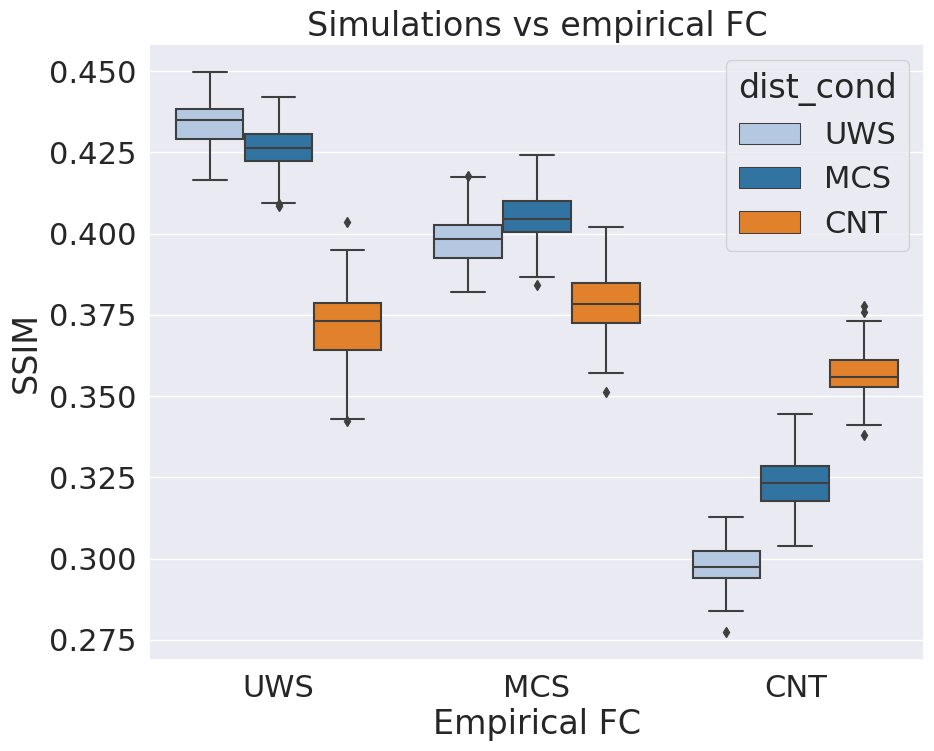

In [63]:
from statannot import add_stat_annotation
# Define the scaling factor
scaling_factor = 2

# Apply the scaling factor to the original figure size and font size
fig_width = 5 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor

sns.set_theme(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'} # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
bxplt = sns.boxplot(df, x='cond', y='SSIM', hue='dist_cond', ax=ax,palette=baseline_colors)


plt.title(f"Simulations vs empirical FC")
plt.ylabel("SSIM")
plt.xlabel("Empirical FC")
plt.savefig(f"plots/Figure2/StatDifferenceBetweenModels.svg", bbox_inches='tight')
plt.savefig(f"plots/Figure2/StatDifferenceBetweenModels.png", bbox_inches='tight')
plt.show()


Kruskal-Wallis p-value: 6.42947026285352e-09


/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:60: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


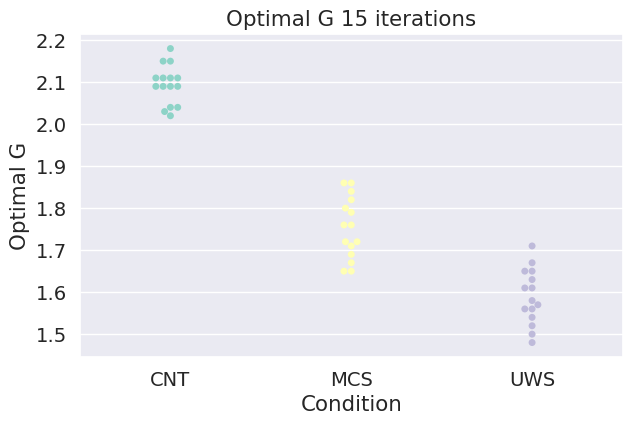

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway
from scipy.stats import kruskal
# Generate sample data
n = 251
repetitions = 15
scaling = np.linspace(0, 2.5, n)
MCS_fit = loadmat("./Results/MCS_Stat_results_15")['FittSSIM_all_mcs']
CNT_fit = loadmat("./Results/CNT_Stat_results_15")['FittSSIM_all_cnt']
UWS_fit = loadmat("./Results/UWS_Stat_results_15")['FittSSIM_all_uws']

data = []

for rep in range(UWS_fit.shape[0]):
    for i in range(UWS_fit.shape[1]):
        data.append(['UWS', UWS_fit[rep, i], scaling[i], rep + 1])

for rep in range(MCS_fit.shape[0]):
    for i in range(MCS_fit.shape[1]):
        data.append(['MCS', MCS_fit[rep, i], scaling[i], rep + 1])

for rep in range(CNT_fit.shape[0]):
    for i in range(CNT_fit.shape[1]):
        data.append(['CNT', CNT_fit[rep, i], scaling[i], rep + 1])

df = pd.DataFrame(data, columns=['condition', 'SSIM', 'scaling', 'rep'])

optimal_values = df.groupby(['condition', 'rep'])['SSIM'].idxmax()
optimal_df = df.loc[optimal_values]
# Perform Kruskal-Wallis test
kruskal_result = kruskal(
    optimal_df[optimal_df['condition'] == 'CNT']['scaling'],
    optimal_df[optimal_df['condition'] == 'MCS']['scaling'],
    optimal_df[optimal_df['condition'] == 'UWS']['scaling']
                         )

print("Kruskal-Wallis p-value:", kruskal_result.pvalue)


# Define the scaling factor
scaling_factor = 1.4
# Apply the scaling factor to the original figure size and font size
fig_width = 5 * scaling_factor
fig_height = 3 * scaling_factor
font_size = 11 * scaling_factor
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

plt.figure(figsize=(fig_width, fig_height))
sns.swarmplot(data=optimal_df, x='condition', y='scaling', palette='Set3')

mean_lines = optimal_df.groupby('condition')['scaling'].mean()
#for condition, mean_value in mean_lines.items():
#    plt.axhline(y=mean_value, color='red', linestyle='--', label=f'Mean ({condition})')


plt.xlabel("Condition")
plt.ylabel("Optimal G")
plt.title("Optimal G 15 iterations")
plt.xticks()
plt.yticks()
plt.savefig(f"plots/Figure2/OptimalGs.svg", bbox_inches='tight')
plt.savefig(f"plots/Figure2/OptimalGs.png", bbox_inches='tight')
plt.show()

### Curves

In [18]:
optimal_df.groupby('condition')['scaling'].std()

condition
CNT    0.046414
MCS    0.073062
UWS    0.065625
Name: scaling, dtype: float64

In [19]:
optimal_df.groupby('condition')['scaling'].mean()

condition
CNT    2.094000
MCS    1.753333
UWS    1.589333
Name: scaling, dtype: float64

1.589333333333333
1.7533333333333334
2.0939999999999994


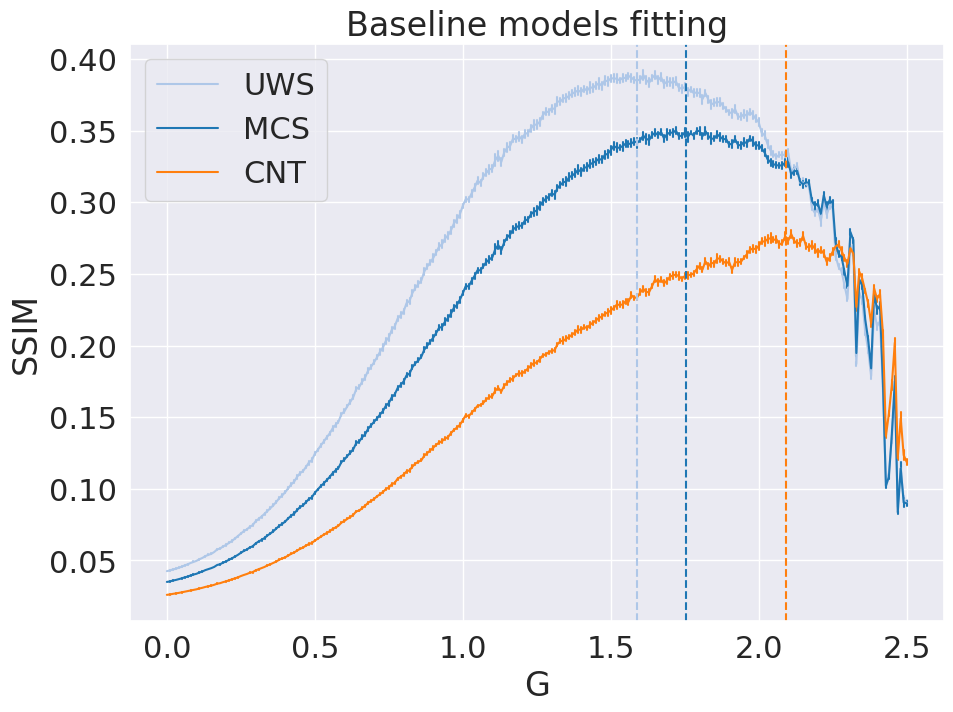

In [20]:

# Define the scaling factor
scaling_factor = 1.5
fig_width = 7 * scaling_factor
fig_height = 5 * scaling_factor
font_size = 16 * scaling_factor
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'} # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot
baseline_cmap_cond2num = {'CNT': 2, 'UWS': 0, 'MCS': 1}
palette = sns.color_palette("viridis", n_colors=101)

hue_values = np.array(['UWS', 'MCS', 'CNT'])#df["condition"].unique()
baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

n = 251
repetitions = 15
scaling = np.linspace(0, 2.5, n)
MCS_fit = loadmat("./Results/MCS_Stat_results_15")['FittSSIM_all_mcs']
CNT_fit = loadmat("./Results/CNT_Stat_results_15")['FittSSIM_all_cnt']
UWS_fit = loadmat("./Results/UWS_Stat_results_15")['FittSSIM_all_uws']

data = []

for rep in range(UWS_fit.shape[0]):
    for i in range(UWS_fit.shape[1]):
        data.append(['UWS', UWS_fit[rep, i], scaling[i], rep + 1])

for rep in range(MCS_fit.shape[0]):
    for i in range(MCS_fit.shape[1]):
        data.append(['MCS', MCS_fit[rep, i], scaling[i], rep + 1])

for rep in range(CNT_fit.shape[0]):
    for i in range(CNT_fit.shape[1]):
        data.append(['CNT', CNT_fit[rep, i], scaling[i], rep + 1])

df = pd.DataFrame(data, columns=['condition', 'SSIM', 'scaling', 'rep'])
sns.lineplot(data=df, x="scaling", y="SSIM", hue="condition", palette=baseline_colors,err_style="bars", errorbar=("se", 2))
mean_lines = optimal_df.groupby('condition')['scaling'].mean()
for idx, hue in enumerate(hue_values):    
    mean_value = mean_lines[hue]    
    line_color = baseline_colors[idx]#baseline_colors[idx]#sns.color_palette()[hue_values.tolist().index(hue)]
    ax.axvline(x=mean_value, color=line_color, linestyle="--")
    print(mean_value)
    
ax.legend(labels=["UWS", "MCS", "CNT"])
legend = ax.get_legend()
legend.set_title("")
ax.set_title("Baseline models fitting")
ax.set_xlabel("G")
ax.set_ylabel("SSIM")
plt.xticks()
plt.yticks()
plt.savefig(f"plots/Figure2/FittingCurves.svg", bbox_inches='tight')
plt.savefig(f"plots/Figure2/FittingCurves.png", bbox_inches='tight')
plt.show()


# Fig 3 

### Baseline Projections

OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149378 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149426 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149427 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149428 thread 4 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149429 thread 5 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149430 thread 6 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149431 thread 7 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149432 thread 8 bound to OS proc set 8
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149433 thread 9 bound to OS proc set 9
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149434 thread 10 bound to OS proc set 10
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149435 thread 11 bound to OS proc set 11
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149

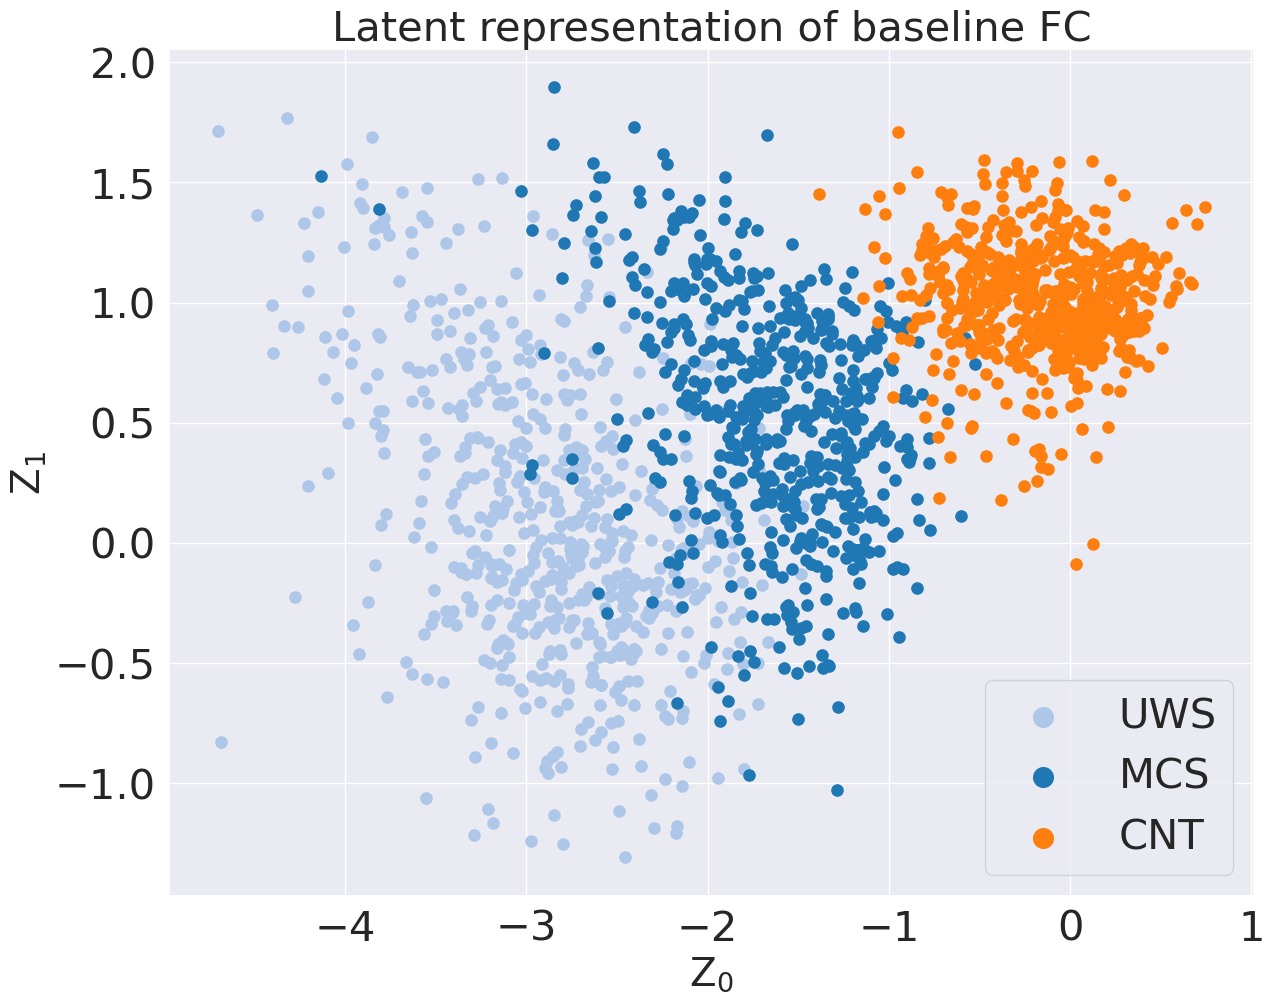

In [22]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

sns.set_theme()

models = vae.get_layer('encoder'),vae.get_layer('decoder')
baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'} # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]]) # This is a problem of inconsistency between how i labeled the data to train and how i labeled to plot


plt.figure(figsize=(14, 11))
for idx,cluster_points in enumerate(latetnt_clusters):
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65)

BETA = np.arange(0,1.01,0.01)

plt.xlabel("Z$_0$",fontsize=28)
plt.ylabel("Z$_1$",fontsize=28)
legend = plt.legend(fontsize=30)
for lh in legend.legendHandles:
    lh._sizes = [200]  # Adjust the marker size as needed

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Latent representation of baseline FC", fontsize=30)
plt.savefig(f"plots/Figure3/BaselineCentroids.svg", dpi=600, bbox_inches='tight')
plt.savefig(f"plots/Figure3/BaselineCentroids.png", dpi=600, bbox_inches='tight')
plt.show()



Cohens d =:2.6662357729690362


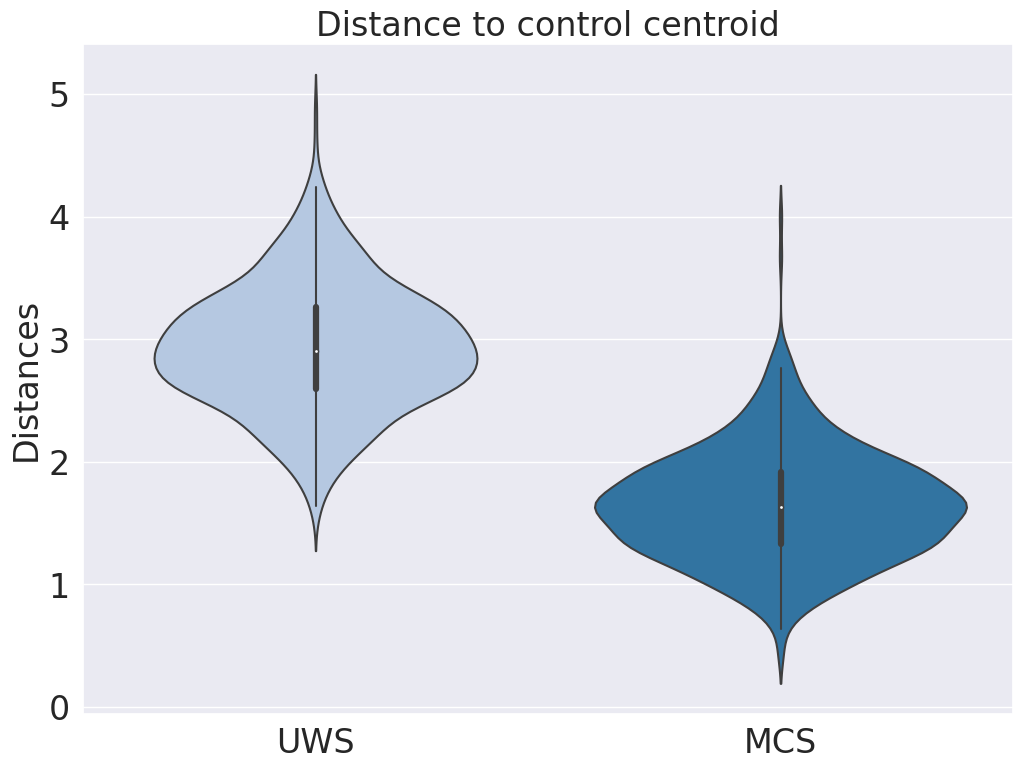

In [24]:
import pandas as pd
import numpy as np


scaling_factor = 2
fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor

uws_distances = np.linalg.norm(latetnt_clusters[0] - cnt_centroid, axis=1)
mcs_distances = np.linalg.norm(latetnt_clusters[1] - cnt_centroid, axis=1)

data = pd.DataFrame({
    'Distance': np.concatenate([uws_distances, mcs_distances]),
    'Cond': ['UWS'] * len(uws_distances) + ['MCS'] * len(mcs_distances)
})


fig, ax = plt.subplots(figsize=(fig_width, fig_height+0.7)) 
vlplt = sns.violinplot(data,x='Cond', y='Distance',palette=baseline_colors, showmedians=True, widths=0.7, showextrema=False)


calc_cohensd(data[data['Cond']=='UWS']['Distance'],data[data['Cond']=='MCS']['Distance'])
   
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(baseline_colors[i])
plt.xticks([0, 1], ['UWS','MCS'], fontsize=font_size)
plt.xlabel('')

plt.ylabel('Distances', fontsize=font_size)
plt.title('Distance to control centroid', fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure3/Distance2CNTCentroid.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure3/Distance2CNTCentroid.png", bbox_inches='tight')
plt.show()

## Grid FC sampling

In [26]:
XLIM = (-5, 1)
YLIM = (-2,2)

OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149458 thread 34 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149459 thread 35 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149463 thread 39 bound to OS proc set 7
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149462 thread 38 bound to OS proc set 6
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149464 thread 40 bound to OS proc set 8
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149461 thread 37 bound to OS proc set 5
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149465 thread 41 bound to OS proc set 9
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149460 thread 36 bound to OS proc set 4
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149467 thread 43 bound to OS proc set 11
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149466 thread 42 bound to OS proc set 10
OMP: Info #254: KMP_AFFINITY: pid 1136109 tid 1149468 thread 44 bound to OS proc set 12
OMP: Info #254: KMP_AFFINITY: pid 113610

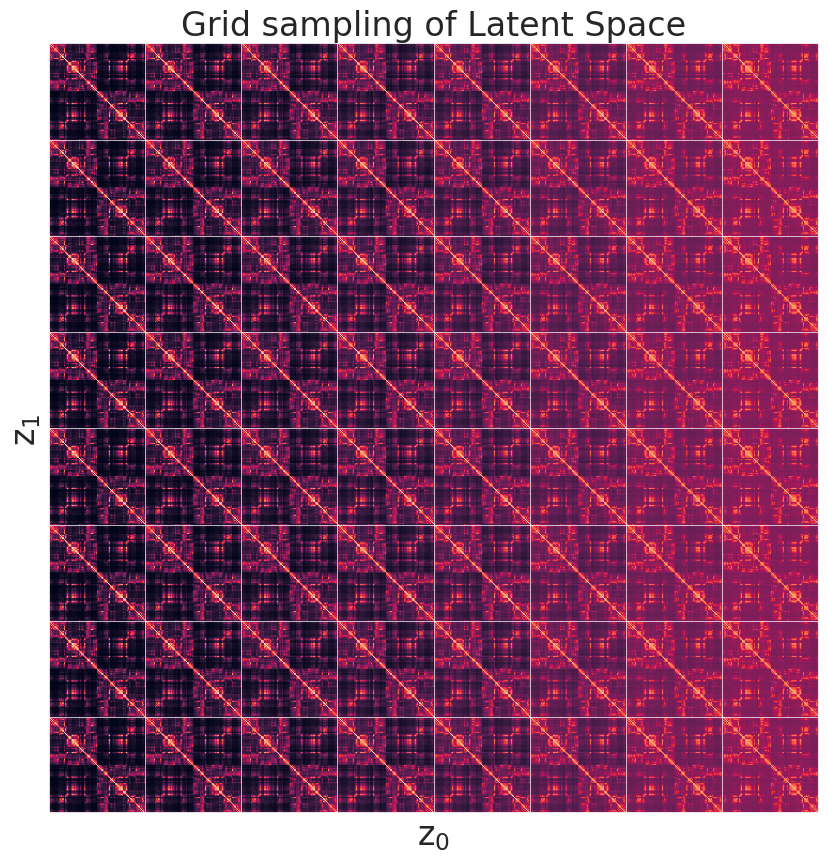

In [27]:

scaling_factor = 1.5

fig_width = 7 * scaling_factor
fig_height = 3 * scaling_factor
font_size = 16 * scaling_factor



os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "vae_mean.png")

cmap = {0: 'CNT', 1: 'UWS', 2: 'MCS'}
colors = ['blue', 'green', 'red']


z_mean, _, _ = encoder.predict([x_test,y_test], batch_size=batch_size)

n = 10
digit_size = 90
n_x = 8
n_y = 8
figure = np.zeros((digit_size * n_y, digit_size * n_x))


grid_x = np.linspace(XLIM[0], XLIM[1], n_x)
grid_y = np.linspace(YLIM[0], YLIM[0], n_y)[::-1]
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.hstack((xi, yi)).reshape(1, 2)#np.array([xi, yi])
        label_input = np.array([yi]).reshape(1,1)
        x_decoded = decoder.predict([z_sample,label_input])        
        digit = x_decoded[0][:8100].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(15, 10))
start_range = digit_size // 2
end_range_x = (n_x - 1) * digit_size + start_range + 1
pixel_range_x = np.arange(start_range, end_range_x, digit_size)
start_range = digit_size // 2
end_range_y = (n_y - 1) * digit_size + start_range + 1
pixel_range_y = np.arange(start_range, end_range_y, digit_size)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

plt.xticks([])
plt.yticks([])
plt.xlabel("z$_0$")
plt.ylabel("z$_1$")

plt.imshow(figure) #cmap='Greys_r')
plt.grid(color='w', linewidth=2)
plt.title("Grid sampling of Latent Space")
    
for i in range(1, n_y):
    plt.axhline(i * digit_size - 0.5, color='white', linewidth=0.5)
for j in range(1, n_x):
    plt.axvline(j * digit_size - 0.5, color='white', linewidth=0.5)

plt.savefig("plots/Figure3/GridSampling.svg",bbox_inches = 'tight')
plt.savefig("plots/Figure3/GridSampling.png",bbox_inches = 'tight')

plt.show()




## Modularity and integration analysis

In [28]:
import numpy as np
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt
from scipy import stats
SC = stats.zscore(loadmat(os.path.join("./Results","ts_coma24_AAL_symm_withSC.mat"))['SC'])
sc_matrix_binary = np.where(SC>0, 1, 0)
triu_idx = np.triu_indices(SC.shape[1],1)


import numpy as np
from skimage import measure
def k_percent_threshold(matrix, k):
    max_val = np.max(matrix)
    threshold = k / 100.0 * max_val
    binary_matrix = np.where(matrix >= threshold, 1, 0)
    return binary_matrix

def get_fractal_dimension(fc_matrix):
    threshold = np.mean(fc_matrix)
    binary_fc_matrix = k_percent_threshold(fc_matrix,50)


    box_counts = []
    box_sizes = []

    for box_size in range(1, min(binary_fc_matrix.shape)//2):

        boxes_per_row = binary_fc_matrix.shape[0] // box_size
        boxes_per_col = binary_fc_matrix.shape[1] // box_size
        occupied_boxes = np.sum(binary_fc_matrix[:boxes_per_row*box_size, :boxes_per_col*box_size].reshape(boxes_per_row, box_size, boxes_per_col, box_size), axis=(1, 3)) > 0
        box_counts.append(np.sum(occupied_boxes))
        box_sizes.append(box_size)

    coeffs = np.polyfit(np.log(box_sizes), np.log(box_counts), 1)
    fractal_dimension = -coeffs[0]
    return fractal_dimension

def mod_int_and_corr(FC):
    G = nx.from_numpy_array(FC)
    corr = stats.pearsonr(FC[triu_idx[0],triu_idx[1]], SC[triu_idx[0],triu_idx[1]])[0]
    threshold = 0.1
    edges_to_remove = []
    for u, v, d in G.edges(data=True):
        if d["weight"] < threshold:
            edges_to_remove.append((u, v))

    for u, v in edges_to_remove:
        G.remove_edge(u, v)
    partition = community_louvain.best_partition(G)
    modularity = community_louvain.modularity(partition, G)
    binarized_fc = k_percent_threshold(FC,50)
    frac_dim = get_fractal_dimension(binarized_fc)
    lzcomplexity = LZ76(binarized_fc)/810

    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()

    try:
        avg_shortest_path_length = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        print("Graph is not connected, cannot compute average shortest path length.")
    return modularity,avg_shortest_path_length,corr,lzcomplexity,frac_dim


In [29]:
from lz76 import LZ76
#
grid_x_range = (XLIM[0], XLIM[1])
grid_x_size = 32
grid_y_range = (YLIM[0], YLIM[1])
grid_y_size = 16


grid_x = np.linspace(grid_x_range[0], grid_x_range[1], grid_x_size)
grid_y = np.linspace(grid_y_range[0], grid_y_range[1], grid_y_size)[::-1]
digit_size = 90

total_size_x = digit_size * grid_x_size
total_size_y = digit_size * grid_y_size


figure_mod = np.zeros((total_size_y, total_size_x))
figure_int = np.zeros((total_size_y, total_size_x))
figure_corr = np.zeros((total_size_y, total_size_x))
figure_lzc = np.zeros((total_size_y, total_size_x))
figure_frac_dim = np.zeros((total_size_y, total_size_x))



mod_min = np.inf  
mod_max = -np.inf  
int_min = np.inf  
int_max = -np.inf  
RECORD = False
if RECORD:
    print("Running everything again")
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.hstack((xi, yi)).reshape(1, 2)
            label_input = np.array([yi]).reshape(1,1)
            x_decoded = decoder.predict([z_sample,label_input])
            fc_matrix = x_decoded[0][:8100].reshape(digit_size, digit_size)

            modularity, integration, corr, lzc, frac_dim = mod_int_and_corr(fc_matrix)

            # Calculate the indices for the current region
            start_row = i * digit_size
            end_row = (i + 1) * digit_size
            start_col = j * digit_size
            end_col = (j + 1) * digit_size

            figure_mod[start_row:end_row, start_col:end_col] = modularity
            figure_int[start_row:end_row, start_col:end_col] = integration
            figure_corr[start_row:end_row, start_col:end_col] = corr
            figure_lzc[start_row:end_row, start_col:end_col] = lzc
            figure_frac_dim[start_row:end_row, start_col:end_col] = frac_dim

            # Update minimum and maximum values
            mod_min = min(mod_min, modularity)
            mod_max = max(mod_max, modularity)
            int_min = min(int_min, integration)
            int_max = max(int_max, integration)

    with open(f"models/{EXP_NAME}lzc.npy", 'wb') as f:
        np.save(f,figure_lzc)

    with open(f"models/{EXP_NAME}mod.npy", 'wb') as f:
        np.save(f,figure_mod)

    with open(f"models/{EXP_NAME}int.npy", 'wb') as f:
        np.save(f,figure_int)

    with open(f"models/{EXP_NAME}corr.npy", 'wb') as f:
        np.save(f,figure_corr)

    with open(f"models/{EXP_NAME}frac_dim.npy", 'wb') as f:
        np.save(f,figure_frac_dim)
else:
    print("Loading previous grid analysis")
    with open(f"models/{EXP_NAME}lzc.npy", 'rb') as f:
        figure_lzc = np.load(f)

    with open(f"models/{EXP_NAME}mod.npy", 'rb') as f:
        figure_mod = np.load(f)

    with open(f"models/{EXP_NAME}int.npy", 'rb') as f:
        figure_int = np.load(f)

    with open(f"models/{EXP_NAME}corr.npy", 'rb') as f:
        figure_corr = np.load(f)

    with open(f"models/{EXP_NAME}frac_dim.npy", 'rb') as f:
        figure_frac_dim = np.load(f)


Loading previous grid analysis


## Grids of metrics

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


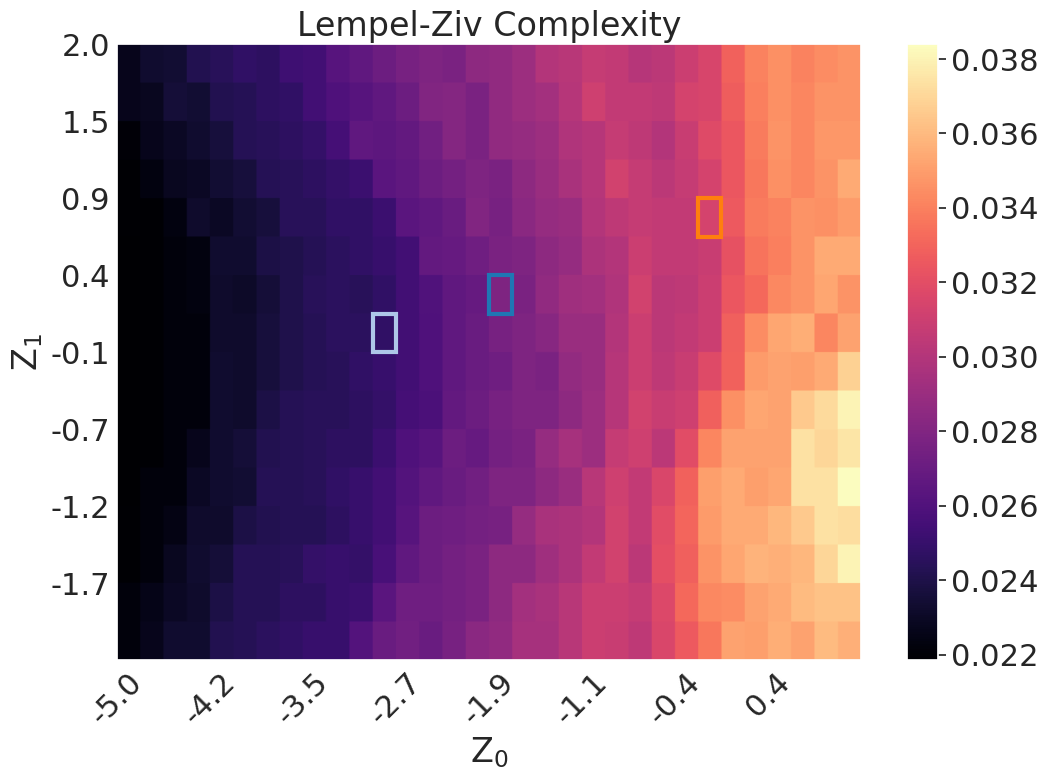

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:86: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


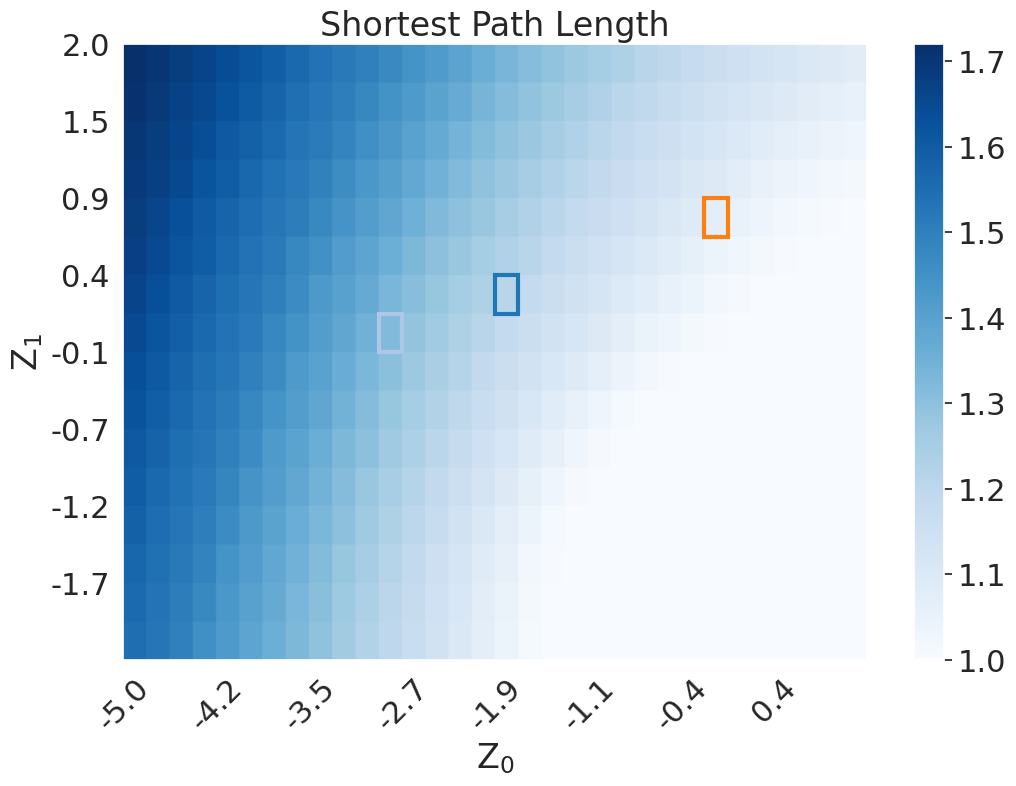

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:115: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


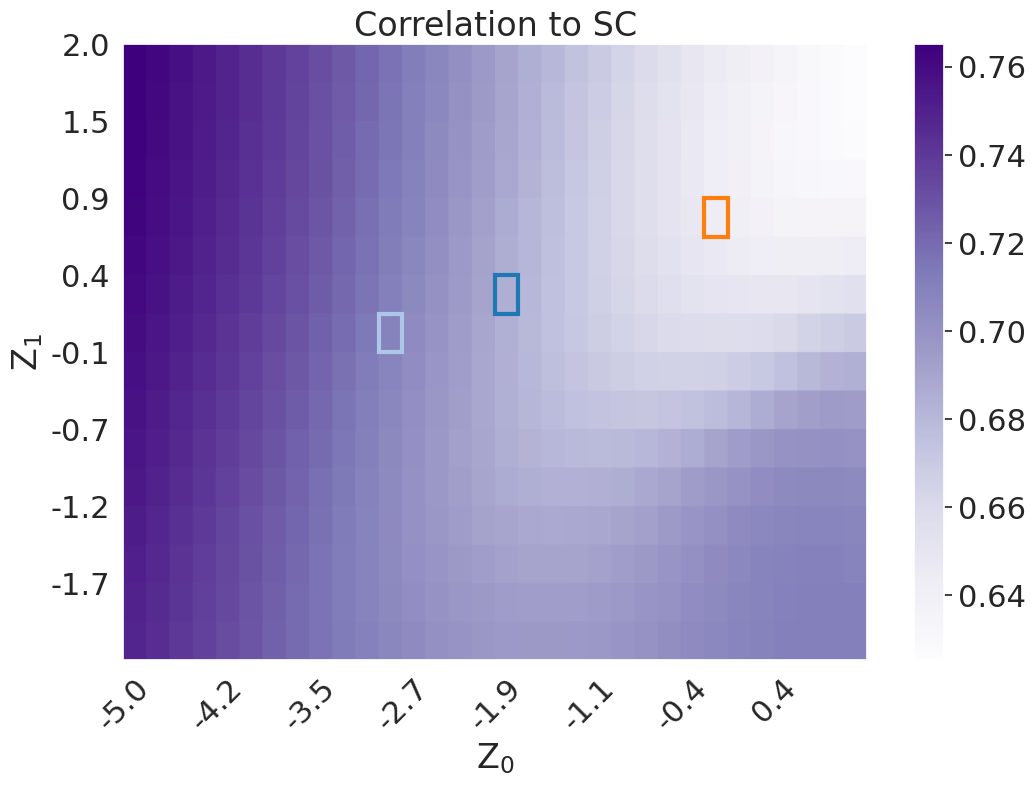

In [30]:
import matplotlib.pyplot as plt


scaling_factor = 2

fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor


uws_row = 7
uws_col = 11
uws_start_row = uws_row * digit_size
uws_end_row = (uws_row + 1) * digit_size
uws_start_col = uws_col * digit_size
uws_end_col = (uws_col + 1) * digit_size
mcs_row = 6
mcs_col = 16
mcs_start_row = mcs_row * digit_size
mcs_end_row = (mcs_row + 1) * digit_size
mcs_start_col = mcs_col * digit_size
mcs_end_col = (mcs_col + 1) * digit_size
cnt_row = 4
cnt_col = 25
cnt_start_row = cnt_row * digit_size
cnt_end_row = (cnt_row + 1) * digit_size
cnt_start_col = cnt_col * digit_size
cnt_end_col = (cnt_col + 1) * digit_size



sns.set(style="darkgrid", font_scale=font_size / 12)  
plt.figure(figsize=(fig_width, fig_height))
plt.imshow(figure_lzc, cmap='magma', vmin=np.min(figure_lzc), vmax=np.max(figure_lzc), norm=plt.Normalize(), aspect='auto')
cbar = plt.colorbar()  




plt.gca().add_patch(plt.Rectangle((uws_start_col, uws_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[0], linewidth=3))
plt.gca().add_patch(plt.Rectangle((mcs_start_col, mcs_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[1], linewidth=3))
plt.gca().add_patch(plt.Rectangle((cnt_start_col, cnt_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[2], linewidth=3))

x_ticks = np.arange(0, total_size_x, digit_size)
y_ticks = np.arange(0, total_size_y, digit_size)


x_tick_labels = ["" if i % 4 != 0 else np.round(grid_x, 1)[i] for i in range(len(x_ticks))]
y_tick_labels = ["" if i % 2 != 0 else np.round(grid_y, 1)[i] for i in range(len(y_ticks))]



plt.xticks(x_ticks, x_tick_labels, rotation=45)
plt.yticks(y_ticks, y_tick_labels)



for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    cur_ticl = np.round(grid_x, 1)[i]    
    if i % 2 != 0:
        tick.set_visible(False)


for i, tick in enumerate(plt.gca().yaxis.get_major_ticks()):
    if i % 2 != 0:
        tick.set_visible(False)

plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")


plt.tick_params(axis='both', which='both', length=0, pad=5)

plt.grid(color='w', linewidth=2)
plt.title("Lempel-Ziv Complexity")
plt.savefig(f"plots/Figure3/complexity.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/complexity.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.imshow(figure_int, cmap='Blues', vmin=np.min(figure_int), vmax=np.max(figure_int), norm=plt.Normalize(), aspect='auto')
cbar = plt.colorbar()  

x_ticks = np.arange(0, total_size_x, digit_size)
y_ticks = np.arange(0, total_size_y, digit_size)

x_tick_labels = ["" if i % 4 != 0 else np.round(grid_x, 1)[i] for i in range(len(x_ticks))]
y_tick_labels = ["" if i % 2 != 0 else np.round(grid_y, 1)[i] for i in range(len(y_ticks))]

           


plt.xticks(x_ticks, x_tick_labels, rotation=45)
plt.yticks(y_ticks, y_tick_labels)
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.gca().add_patch(plt.Rectangle((uws_start_col, uws_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[0] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((mcs_start_col, mcs_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[1] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((cnt_start_col, cnt_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[2] , linewidth=3))
plt.grid(color='w', linewidth=2)
plt.title("Shortest Path Length")
plt.savefig(f"plots/Figure3/integration.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/integration.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
plt.imshow(figure_corr, cmap='Purples', vmin=np.min(figure_corr), vmax=np.max(figure_corr), norm=plt.Normalize(), aspect='auto')
cbar = plt.colorbar()  

x_ticks = np.arange(0, total_size_x, digit_size)
y_ticks = np.arange(0, total_size_y, digit_size)

x_tick_labels = ["" if i % 4 != 0 else np.round(grid_x, 1)[i] for i in range(len(x_ticks))]
y_tick_labels = ["" if i % 2 != 0 else np.round(grid_y, 1)[i] for i in range(len(y_ticks))]

                                                                                          

plt.xticks(x_ticks, x_tick_labels, rotation=45)
plt.yticks(y_ticks, y_tick_labels)

plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.gca().add_patch(plt.Rectangle((uws_start_col, uws_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[0] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((mcs_start_col, mcs_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[1] , linewidth=3))
plt.gca().add_patch(plt.Rectangle((cnt_start_col, cnt_start_row), digit_size, digit_size, 
                                  fill=False, edgecolor=baseline_colors[2] , linewidth=3))
plt.title("Correlation to SC")
plt.grid(color='w', linewidth=2)
plt.savefig(f"plots/Figure3/corr2SC.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/corr2SC.png",bbox_inches = 'tight')
plt.show()


## Metrics distribution in set of projected baseline points

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize empty lists to store metric values for each condition
modularity_values = {'CNT': [], 'UWS': [], 'MCS': []}
integration_values = {'CNT': [], 'UWS': [], 'MCS': []}
corr_values = {'CNT': [], 'UWS': [], 'MCS': []}
lzc_values = {'CNT': [], 'UWS': [], 'MCS': []}
frac_dim_values = {'CNT': [], 'UWS': [], 'MCS': []}

baseline_cmap = {0: 'UWS', 1: 'MCS',2: 'CNT'}
baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1], baseline_colors[0], baseline_colors[2]]
RECORD = False
if RECORD:
    for idx, cluster_points in enumerate(latetnt_clusters):
        unique_points = np.unique(cluster_points,axis=0)
        for x,y in unique_points:     
            z_sample = np.hstack((x, y)).reshape(1, 2)#np.array([xi, yi])
            label_input = np.array([y]).reshape(1,1)
            x_decoded = decoder.predict([z_sample,label_input])
            fc_matrix = x_decoded[0][:8100].reshape(digit_size, digit_size)
            modularity, integration, corr, lzc, frac_dim = mod_int_and_corr(fc_matrix)
            
            # Determine the condition based on idx
            condition = baseline_cmap[idx]
            
            # Append metric values to the respective lists for the condition
            modularity_values[condition].append(modularity)
            integration_values[condition].append(integration)
            corr_values[condition].append(corr)
            lzc_values[condition].append(lzc)
            frac_dim_values[condition].append(frac_dim)

    # Convert metric values to a pandas DataFrame
    metrics_data = pd.DataFrame({
        'Modularity': modularity_values['UWS'] + modularity_values['MCS'] + modularity_values['CNT'],
        'Integration': integration_values['UWS'] + integration_values['MCS'] + integration_values['CNT'],
        'Correlation': corr_values['UWS'] + corr_values['MCS'] + corr_values['CNT'],
        'LZC': lzc_values['UWS'] + lzc_values['MCS'] + lzc_values['CNT'],
        'Fractal Dimension': frac_dim_values['UWS'] + frac_dim_values['MCS'] + frac_dim_values['CNT'],
        'Condition': ['UWS'] * len(modularity_values['UWS']) + ['MCS'] * len(modularity_values['MCS']) + ['CNT'] * len(modularity_values['CNT'])
    })

    metrics_data.to_pickle(f"models/{EXP_NAME}metrics.pkl")


else:
    print("Loading previous grid analysis")
    metrics_data = pd.read_pickle(f"models/{EXP_NAME}metrics.pkl")




Loading previous grid analysis


In [32]:
print("CNT")
print(metrics_data[metrics_data['Condition']=='CNT'].median())
print("IQR")
print(metrics_data[metrics_data['Condition']=='CNT'].quantile(0.75)-metrics_data[metrics_data['Condition']=='CNT'].quantile(0.25))
print("\nUWS")
print(metrics_data[metrics_data['Condition']=='UWS'].median())
print("IQR")
print(metrics_data[metrics_data['Condition']=='UWS'].quantile(0.75)-metrics_data[metrics_data['Condition']=='UWS'].quantile(0.25))
print("\nMCS")
print(metrics_data[metrics_data['Condition']=='MCS'].median())
print("IQR")
print(metrics_data[metrics_data['Condition']=='MCS'].quantile(0.75)-metrics_data[metrics_data['Condition']=='MCS'].quantile(0.25))

CNT
Modularity           0.188313
Integration          1.069413
Correlation          0.643519
LZC                  0.031358
Fractal Dimension    1.775041
dtype: float64
IQR
Modularity           0.036435
Integration          0.064419
Correlation          0.010999
LZC                  0.001975
Fractal Dimension    0.024939
dtype: float64

UWS
Modularity           0.311542
Integration          1.308240
Correlation          0.707494
LZC                  0.024938
Fractal Dimension    1.647096
dtype: float64
IQR
Modularity           0.070030
Integration          0.150312
Correlation          0.021316
LZC                  0.001605
Fractal Dimension    0.022380
dtype: float64

MCS
Modularity           0.249481
Integration          1.179526
Correlation          0.678113
LZC                  0.028272
Fractal Dimension    1.714777
dtype: float64
IQR
Modularity           0.051537
Integration          0.104619
Correlation          0.015090
LZC                  0.001235
Fractal Dimension    0.031145

In [33]:
metrics_data

Modularity  Integration  Correlation       LZC  Fractal Dimension  \
0       0.467441     1.680649     0.758795  0.023210           1.616695   
1       0.419617     1.550562     0.747357  0.022222           1.601135   
2       0.452160     1.640949     0.753598  0.022963           1.616299   
3       0.438200     1.604245     0.750604  0.023086           1.614011   
4       0.436842     1.597503     0.749728  0.022840           1.609679   
...          ...          ...          ...       ...                ...   
1795    0.171183     1.043945     0.629440  0.034444           1.812127   
1796    0.155150     1.017978     0.631911  0.034568           1.814702   
1797    0.153951     1.016230     0.631983  0.034815           1.815732   
1798    0.166869     1.036954     0.629319  0.034568           1.814702   
1799    0.169241     1.040449     0.628523  0.034691           1.816114   

     Condition  
0          UWS  
1          UWS  
2          UWS  
3          UWS  
4          UWS  
...        ...  
1795       CNT  
1796       CNT  
1797       CNT  
1798       CNT  
1799       CNT  

[1800 rows x 6 columns]

In [34]:
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['LZC'],metrics_data[metrics_data['Condition']=='MCS']['LZC'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['LZC'],metrics_data[metrics_data['Condition']=='CNT']['LZC'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['LZC'],metrics_data[metrics_data['Condition']=='CNT']['LZC'])
print("")
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Integration'],metrics_data[metrics_data['Condition']=='MCS']['Integration'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['Integration'],metrics_data[metrics_data['Condition']=='CNT']['Integration'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Integration'],metrics_data[metrics_data['Condition']=='CNT']['Integration'])
print("")
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Correlation'],metrics_data[metrics_data['Condition']=='MCS']['Correlation'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['Correlation'],metrics_data[metrics_data['Condition']=='CNT']['Correlation'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['Correlation'],metrics_data[metrics_data['Condition']=='CNT']['Correlation'])

Cohens d =:-2.693365654920412
Cohens d =:-2.8532091751625464
Cohens d =:-5.129146100446728

Cohens d =:1.337887357598168
Cohens d =:1.7043669209333998
Cohens d =:2.882342297439398

Cohens d =:2.082622609288252
Cohens d =:3.474001829999466
Cohens d =:5.257500187698563


5.257500187698563

Cohens d =:-2.693365654920412
Cohens d =:-2.8532091751625464
Cohens d =:-5.129146100446728


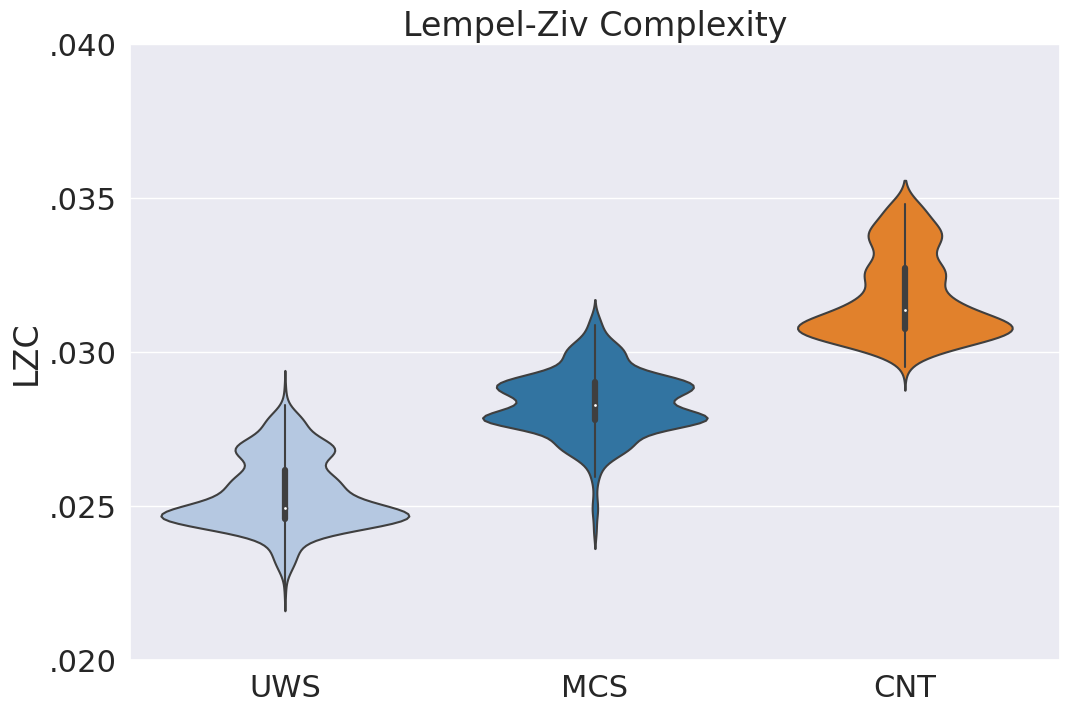

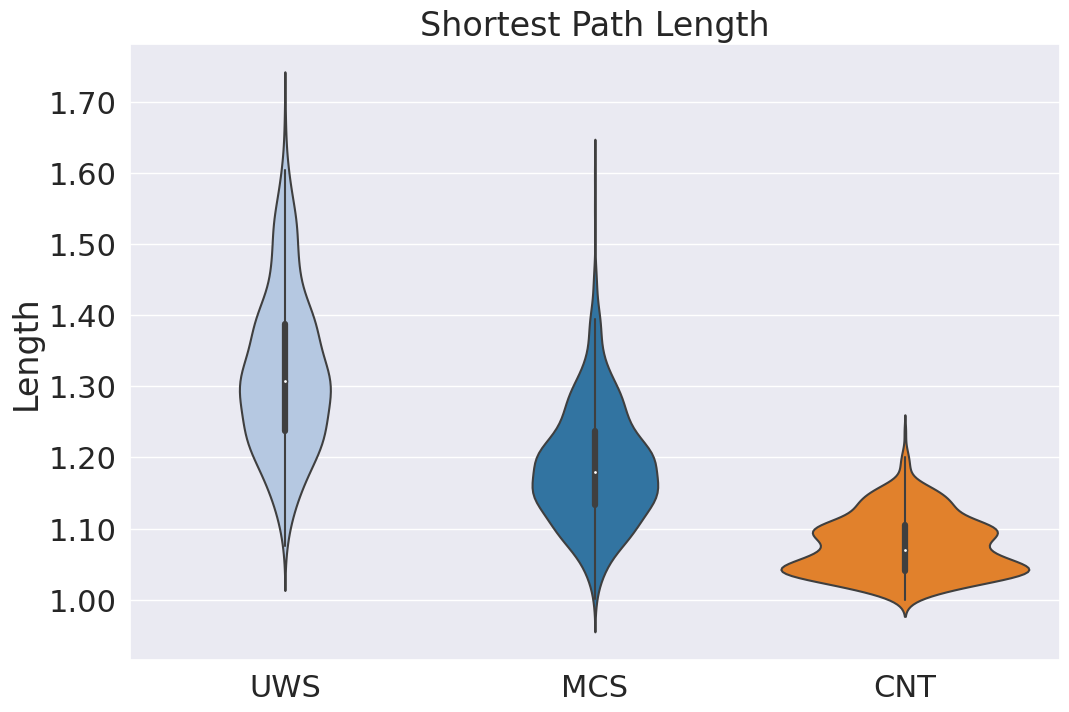

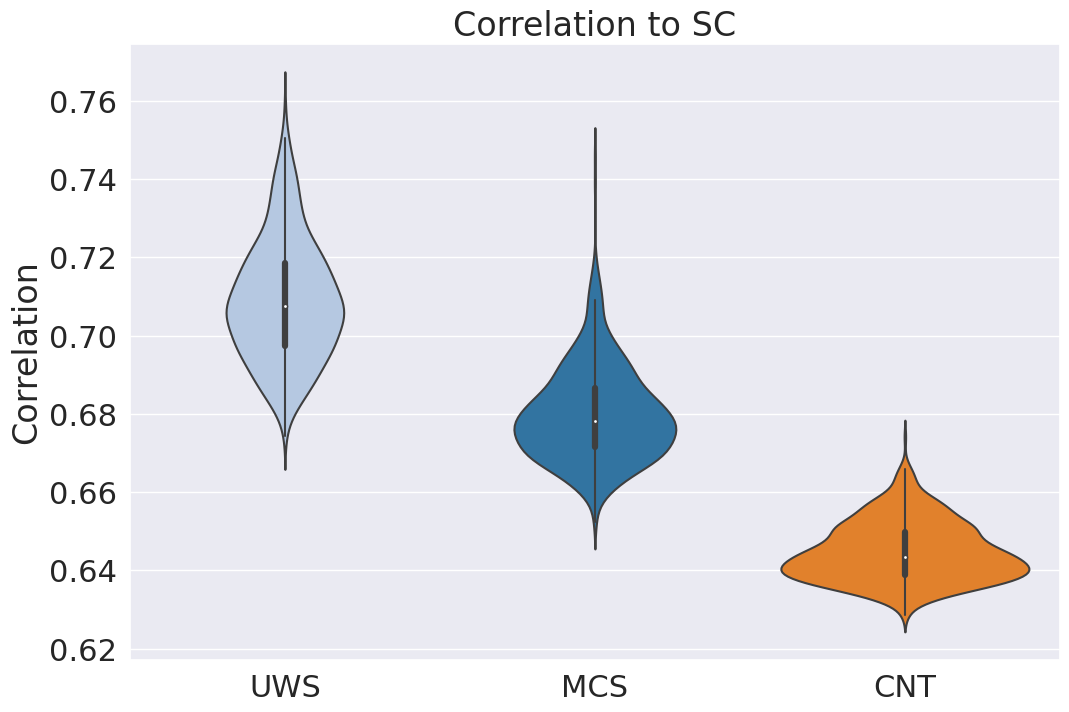

In [35]:
import matplotlib.ticker as ticker

scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 12 * scaling_factor

#
plt.figure(figsize=(fig_width, fig_height))
vlplt = sns.violinplot(x="Condition", y="LZC", data=metrics_data, palette=baseline_colors)


calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['LZC'],metrics_data[metrics_data['Condition']=='MCS']['LZC'])
calc_cohensd(metrics_data[metrics_data['Condition']=='MCS']['LZC'],metrics_data[metrics_data['Condition']=='CNT']['LZC'])
calc_cohensd(metrics_data[metrics_data['Condition']=='UWS']['LZC'],metrics_data[metrics_data['Condition']=='CNT']['LZC'])
plt.ylim(0.02, 0.04)
plt.yticks([0.02, 0.025, 0.03, 0.035, 0.04], ['.020', '.025', '.030', '.035', '.040'])

plt.title("Lempel-Ziv Complexity")
plt.xlabel('')
plt.savefig(f"plots/Figure3/complexityDistribution.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/complexityDistribution.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  
vlplt = sns.violinplot(x="Condition", y="Integration", data=metrics_data, palette=baseline_colors)

plt.title("Shortest Path Length")
plt.xlabel('')
plt.ylabel("Length")
formatter = ticker.FuncFormatter(lambda x, _: f"{x:.2f}")
plt.gca().yaxis.set_major_formatter(formatter)
plt.savefig(f"plots/Figure3/integrationDistribution.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/integrationDistribution.png",bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(fig_width, fig_height))
vlplt = sns.violinplot(x="Condition", y="Correlation", data=metrics_data, palette=baseline_colors)
plt.title("Correlation to SC")
plt.xlabel('')
plt.savefig(f"plots/Figure3/corr2SCDistribution.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure3/corr2SCDistribution.png",bbox_inches = 'tight')
plt.show()

# Fig 4

### Just baseline 

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

sns.set_theme()

models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
#
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test

z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(12, 10))

for idx,cluster_points in enumerate(latetnt_clusters):
    points = np.column_stack((cluster_points[:, 0], cluster_points[:, 1]))
    hull = ConvexHull(points)
    hull_indices = hull.vertices
    hull_points = points[hull_indices]
    hull_points = np.append(hull_points, [hull_points[0]], axis=0)
    plt.plot(hull_points[:, 0], hull_points[:, 1], '-',color=baseline_colors[idx])
    plt.fill(hull_points[:, 0], hull_points[:, 1], facecolor=baseline_colors[idx], alpha=0.3)
    plt.scatter(latent_centroids[idx][0],latent_centroids[idx][1], color=baseline_colors[idx], label=baseline_cmap[idx])
BETA = np.arange(0,1.01,0.01)
plt.xlabel("Z [0]")
plt.ylabel("Z [1]")
plt.legend()
plt.title("Latent representation of baseline FC")
plt.show()



/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


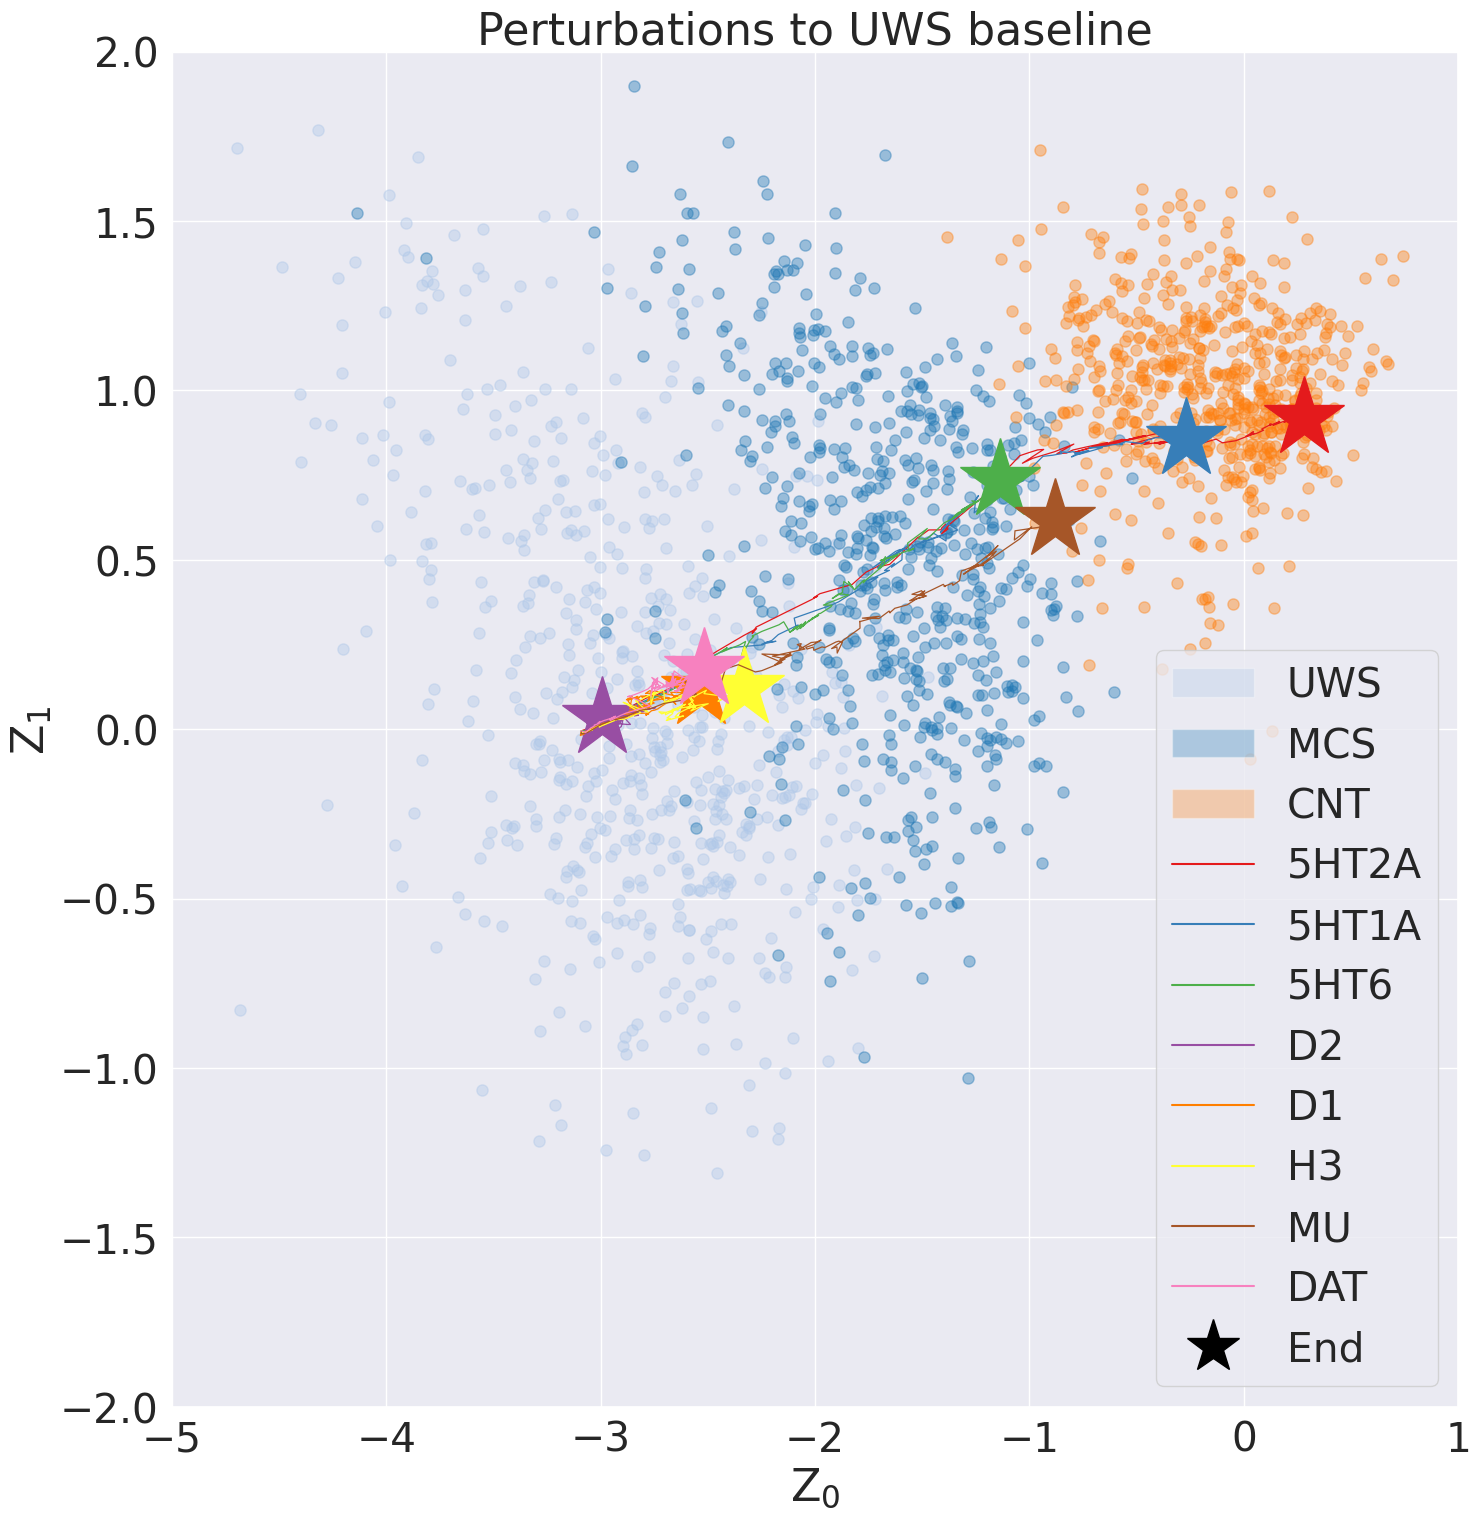

In [36]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 8.3 * scaling_factor
fig_height = 8.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale


models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(fig_width, fig_height))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):

    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)
BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

UWS_distances = []
UWS_maxidx = []

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
UWS_velocities = [] 
for idx,cond in enumerate(conditions):
    perturb_fcs = np.mean(loadmat(f"/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/Results/FC_{cond}_UWS.mat")["FC_simul_all"], axis=0)
    perturb_fcs = perturb_fcs[:101]
    z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(101,90*90)),np.zeros(shape=(101,))], batch_size=batch_size)
    plt.plot(z_perturb[:, 0][:0], z_perturb[:, 1][:0], color='k', marker='X', markevery=[0], markersize=10, linewidth=0.9)
    plt.plot(z_perturb[:, 0], z_perturb[:, 1], color=condition_colors[idx], linewidth=0.9)
    #plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=20)
    plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=60)

    latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
    latent_dist = np.reshape(latent_dist, [101])
    #savemat(os.path.join(base_cluster,"Results",f"UWS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
    UWS_distances.append(np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    UWS_maxidx.append(np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    UWS_velocities.append(calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb))
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.xlim(XLIM[0], XLIM[1])
plt.ylim(YLIM[0], YLIM[1])
plt.xticks()
plt.yticks()

fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', label='End', markersize=40)
]
# Add the legends to the plot
plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="lower right")
for lh in legend.legendHandles:
    lh._sizes = [150]  # Adjust the marker size as needed

plt.title("Perturbations to UWS baseline")
plt.savefig(f"plots/Figure4/UWS_Gain_ALL.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/UWS_Gain_ALL.png",bbox_inches = 'tight')
plt.show()


/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


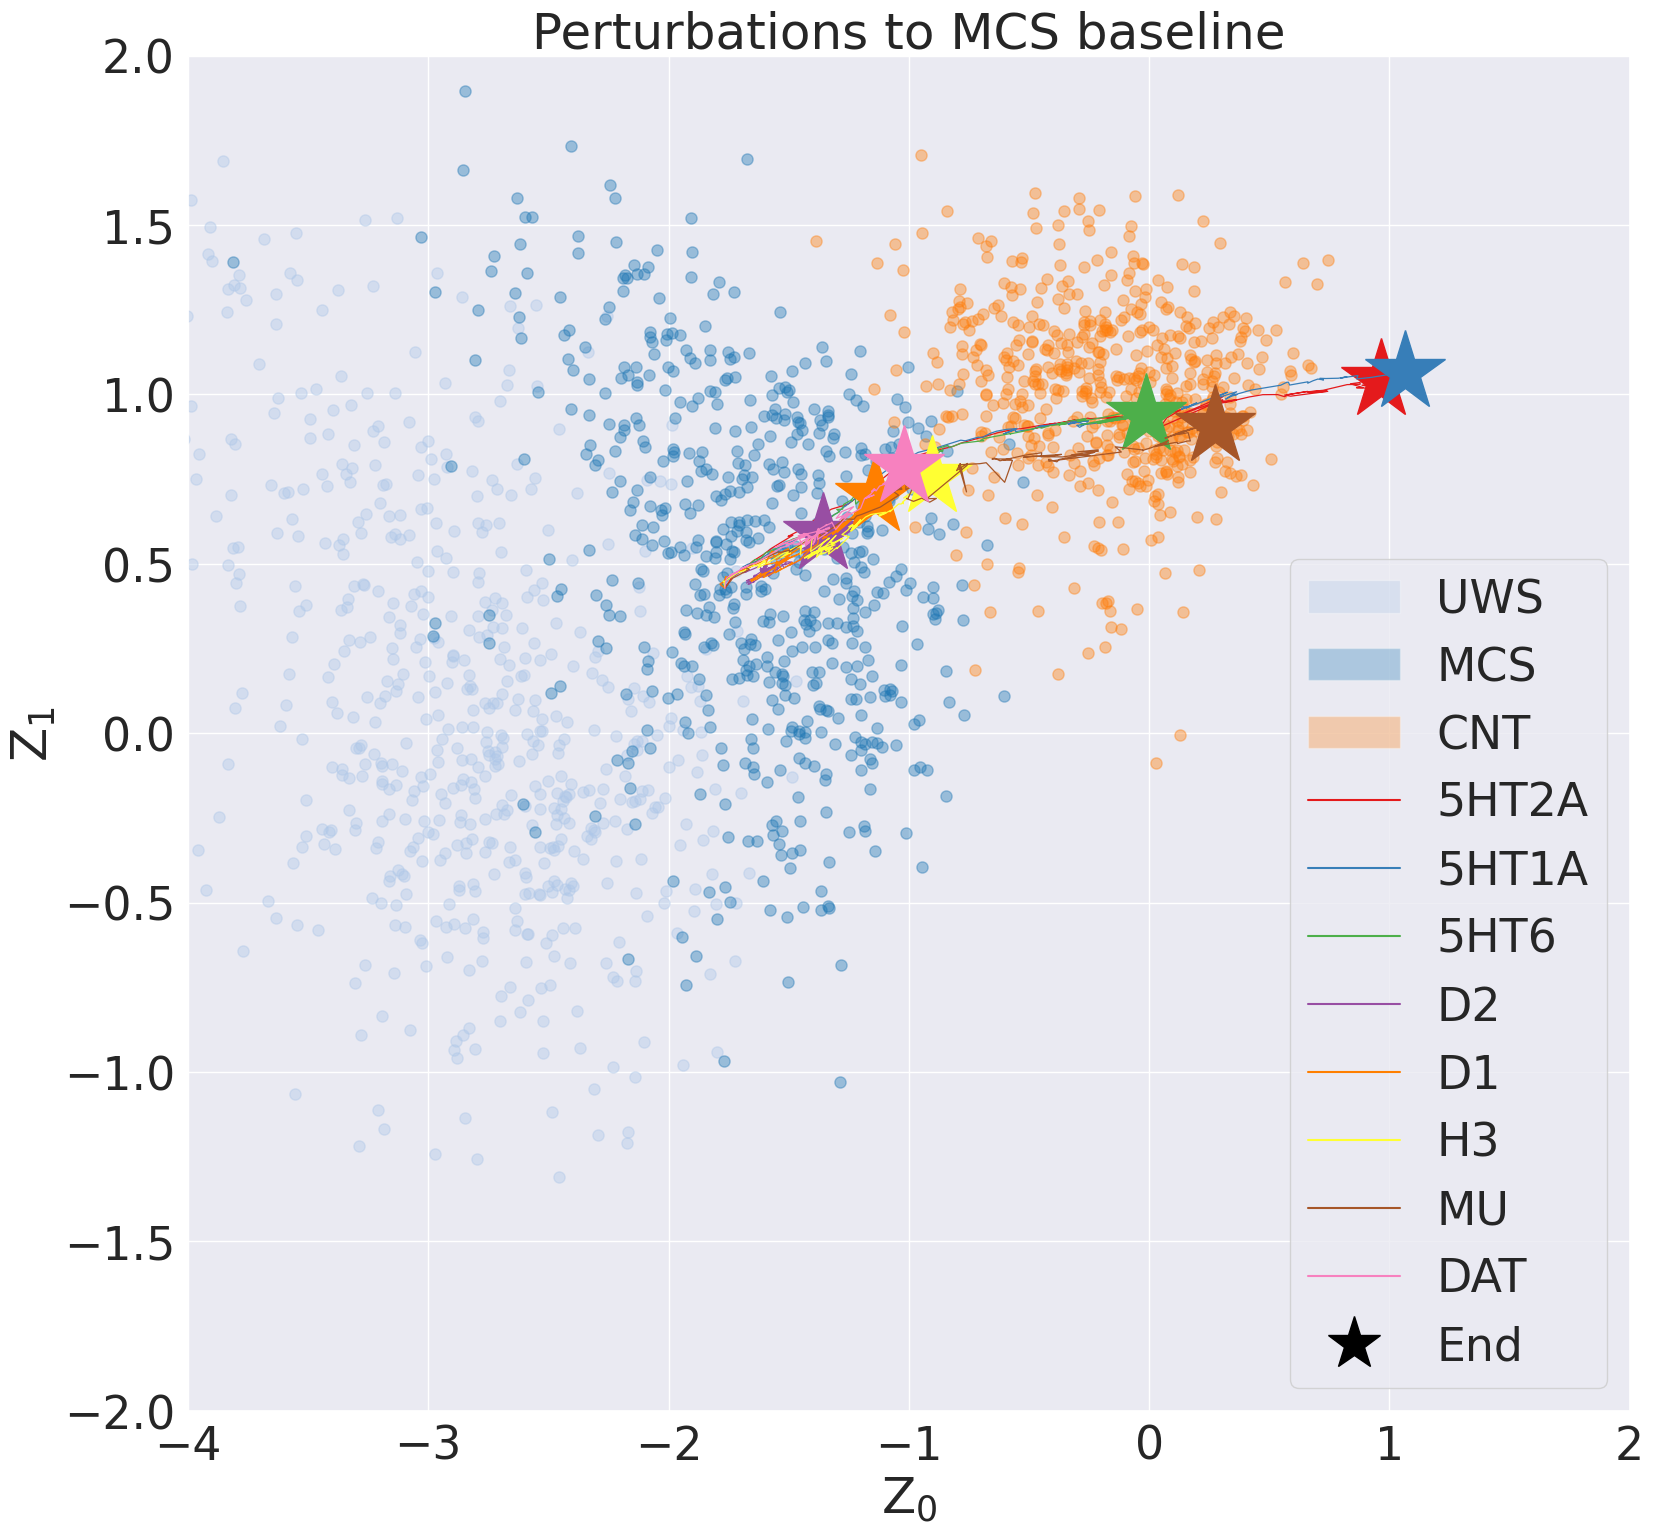

In [37]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl

# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 9.3 * scaling_factor
fig_height = 8.8 * scaling_factor
font_size = 18 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale


models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])


plt.figure(figsize=(fig_width, fig_height))
# Plot the scatter plot for each cluster
for idx,cluster_points in enumerate(latetnt_clusters):
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)
BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

MCS_distances = []
MCS_maxidx = []
#CBDconditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'CB1', 'H3', 'MU','DAT']
conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']
#conditions = ['5HT1A']
condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
MCS_velocities = [] 
for idx,cond in enumerate(conditions):
    perturb_fcs = np.mean(loadmat(f"/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/Results/FC_{cond}_MCS.mat")["FC_simul_all"],axis=0)
    perturb_fcs = perturb_fcs[:101]
    z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(101,90*90)),np.ones((101,))], batch_size=batch_size)
    plt.plot(z_perturb[:, 0][:0], z_perturb[:, 1][:0], color='k', marker='X', markevery=[0], markersize=10, linewidth=0.9)
    plt.plot(z_perturb[:, 0], z_perturb[:, 1], color=condition_colors[idx], linewidth=0.9)
    #plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=20)
    plt.plot(z_perturb[:, 0][-1:], z_perturb[:, 1][-1:], color=condition_colors[idx], marker='*', markersize=60)

    latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
    latent_dist = np.reshape(latent_dist, [101])
    #savemat(os.path.join(base_cluster,"Results",f"MCS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
    MCS_distances.append(np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    MCS_maxidx.append(np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
    MCS_velocities.append(calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb))
plt.xlabel("Z$_0$")
plt.ylabel("Z$_1$")
plt.xlim(XLIM[0]+1, XLIM[1]+1)
plt.ylim(YLIM[0], YLIM[1])
plt.xticks()
plt.yticks()

fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', label='End', markersize=40)
]
# Add the legends to the plot
plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="lower right")
for lh in legend.legendHandles:
    lh._sizes = [150]  # Adjust the marker size as needed


plt.title("Perturbations to MCS baseline")
plt.savefig(f"plots/Figure4/MCS_Gain_ALL.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/MCS_Gain_ALL.png",bbox_inches = 'tight')
plt.show()


/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


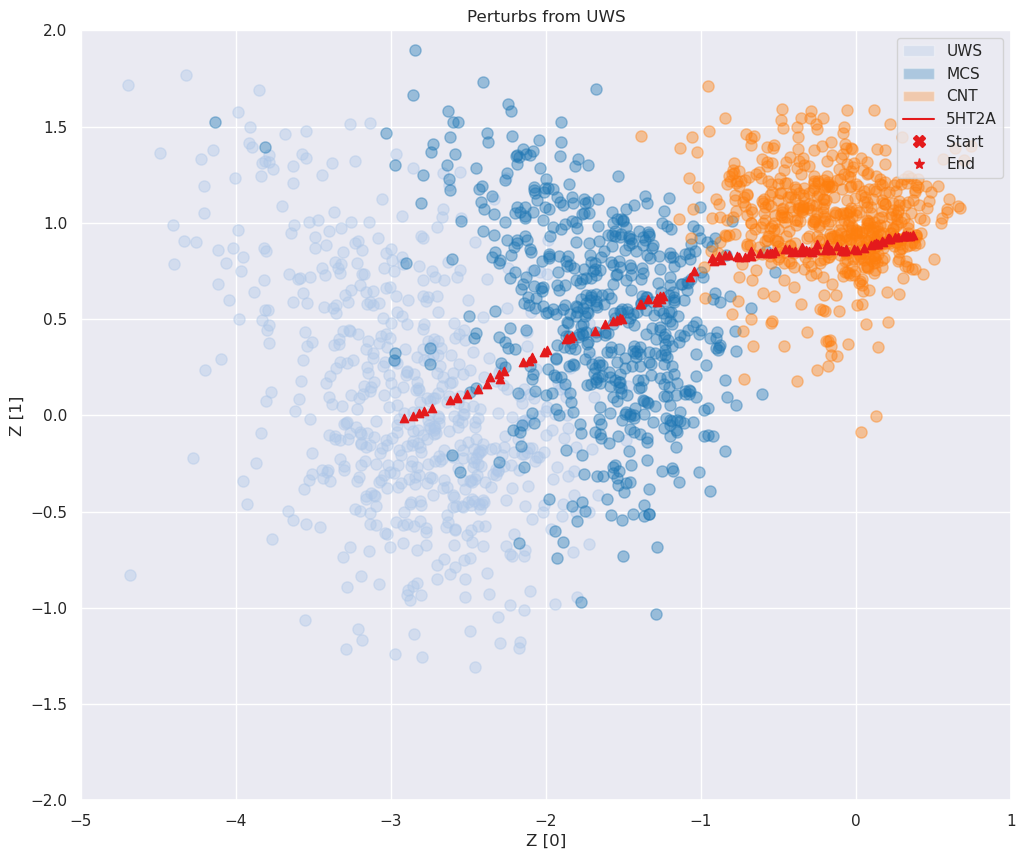

In [38]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import seaborn as sns

sns.set_theme()

models = vae.get_layer('encoder'),vae.get_layer('decoder')
# Tags and palettes
baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
palette = sns.color_palette("viridis", n_colors=101)
baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]

#Calcualte cenntroids
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)
cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])

# PLOT CONDITION CENTROIDS

fig = plt.figure(figsize=(12, 10))
for idx,cluster_points in enumerate(latetnt_clusters):
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],color=baseline_colors[idx], label=baseline_cmap[idx],s=65, alpha=0.4)

# PLOT PERTURBATION
condition_colors =sns.color_palette("Set1", n_colors=len(conditions))
cond = '5HT2A'
cond_idx = 0
perturb_fcs = loadmat(f"/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/Results/FC_{cond}_UWS.mat")["FC_simul_all"]
perturb_fcs = np.mean(perturb_fcs, axis=0)
z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs,(101,90*90)),np.ones((101,))], batch_size=batch_size)
BETA = np.arange(0,1.01,0.01)
conditions = [cond]
# Create handles for the legend
fill_legend_handles = [mpatches.Patch(facecolor=baseline_colors[idx], alpha=0.3, label=baseline_cmap[idx]) for idx in range(3)]
plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

marker_handles = [
    plt.Line2D([0], [0], color=condition_colors[cond_idx], marker='X', linestyle='None', label='Start', markersize=8),
    plt.Line2D([0], [0], color=condition_colors[cond_idx], marker='*', linestyle='None', label='End', markersize=8)
]

gif_folder = "plots/gifs/tmp"
for idx in range(z_perturb.shape[0]):    
    plt.scatter(z_perturb[idx, 0], z_perturb[idx, 1], color=condition_colors[cond_idx], marker='^')    
    plt.xlabel("Z [0]")
    plt.ylabel("Z [1]")
    plt.xlim(XLIM[0], XLIM[1])
    plt.ylim(YLIM[0], YLIM[1])
    # Add the legends to the plot
    plt.legend(handles=fill_legend_handles+plot_legend_handles+marker_handles, loc="upper right")
    plt.title("Perturbs from UWS")
    fig.savefig(f"{gif_folder}/{idx}.png")    
plt.show()

#PLOT gif
from PIL import Image
import glob

image_path = f"{gif_folder}/*.png"  # glob method will grab all the files ending in .png
output_path = "plots/Figure4/perturb_5ht2a.gif"  
# Duration (in milliseconds) between frames
frame_duration = 100
# Sort all the .png files in the path
image_files = sorted(glob.glob(image_path), key=lambda str_fname: int(str_fname.split("/")[-1].split(".")[0])) # Order filenames by their integer, not the string
images = []
for filename in image_files:
    img = Image.open(filename)
    images.append(img)
# save the images as a GIF
images[0].save(output_path,
               save_all=True,
               append_images=images[1:],
               duration=frame_duration,
               loop=0)



## Distance distributions to CNT after perturbing

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


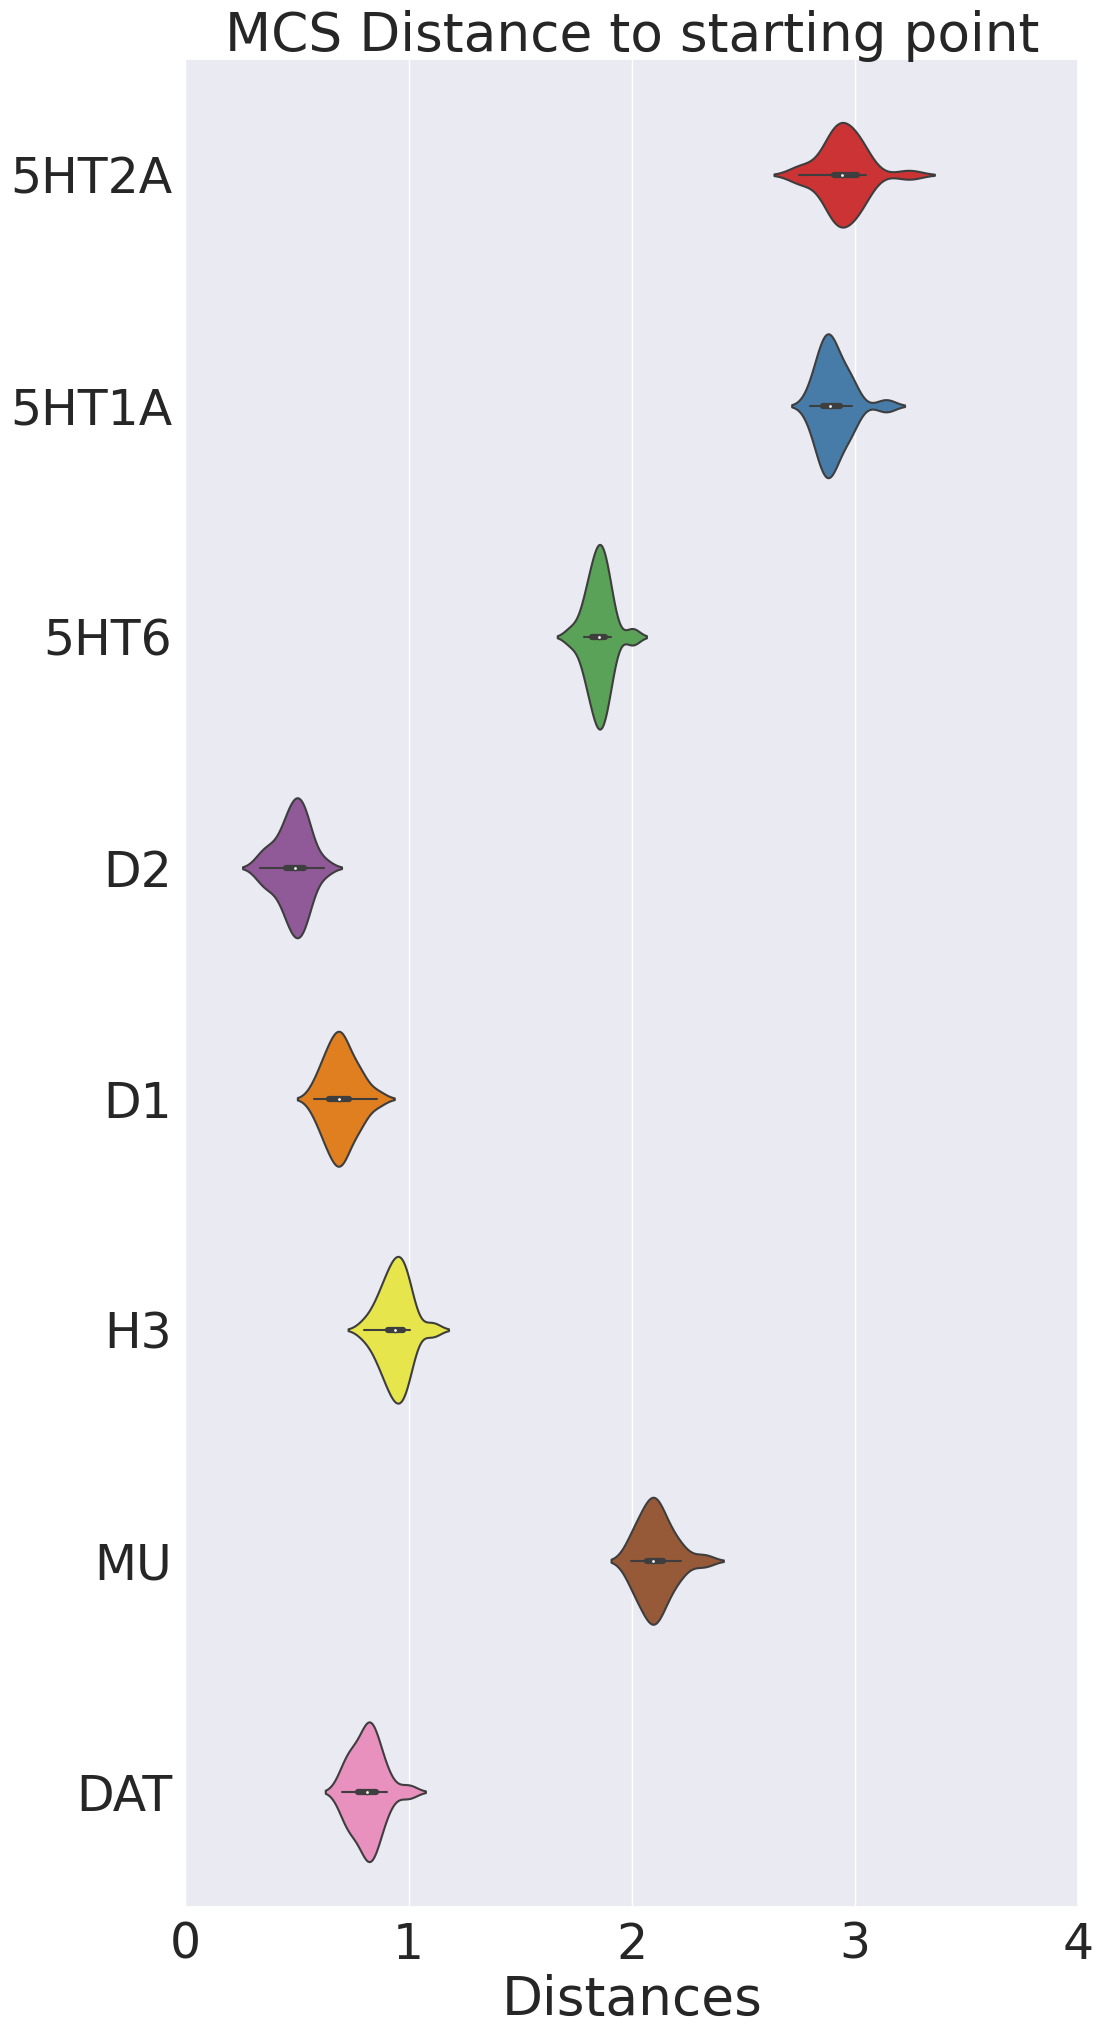

In [39]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl


# Define the scaling factor
scaling_factor = 2.4
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 4.8 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])

BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']
#conditions = ['5HT2A', '5HT1A']
MCS_distances = np.zeros((20, len(conditions)))
MCS_maxidx = np.zeros((20, len(conditions)))
MCS_velocities = np.zeros((20, len(conditions),100)) # We dont take the velocity at time 0, so in total we have 100 points
condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
for idx,cond in enumerate(conditions):
    # CHANGED LOCATION TO STORAGE_DMF_GUS
    perturb_fcs = loadmat(f"/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/Results/FC_{cond}_MCS.mat")["FC_simul_all"] 
    for rep in range(20):
        perturb_fcs_rep = perturb_fcs[rep, :, :,:] # Shape (rep, scale, nreg, nreg)
        z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs_rep,(101,90*90)),np.ones(shape=(101,))], batch_size=batch_size)        

        latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
        latent_dist = np.reshape(latent_dist, [101])
        #savemat(os.path.join(base_cluster,"Results",f"MCS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
        MCS_distances[rep, idx] = (np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        MCS_maxidx[rep, idx] = (np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        MCS_velocities[rep, idx, :] = calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb)

data = MCS_distances

# Create the violin plot
fig, ax = plt.subplots(figsize=(fig_height,fig_width))
sns.violinplot(data,palette=condition_colors, showmedians=True, widths=0.7, showextrema=False, ax=ax, orient='h')

# Set custom colors for each category
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(condition_colors[i])

# Customize the plot
#plt.xticks(np.arange(len(conditions)), conditions, )
ax.set_yticklabels(conditions)
plt.xticks()
#legend_handles = [mpatches.Patch(facecolor=condition_colors[idx],alpha=0.8, label=conditions[idx]) for idx in range(len(conditions))]
#legend = plt.legend(handles=legend_handles, loc='center right')
#for lh in legend.legendHandles:
#    lh._sizes = [200]  # Adjust the marker size as needed
plt.xlim([0,4])
plt.xlabel('Distances')
plt.title('MCS Distance to starting point')
plt.savefig(f"plots/Figure4/MCS_DistanceToStart.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/MCS_DistanceToStart.png",bbox_inches = 'tight')
# Display the plot
plt.show()

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


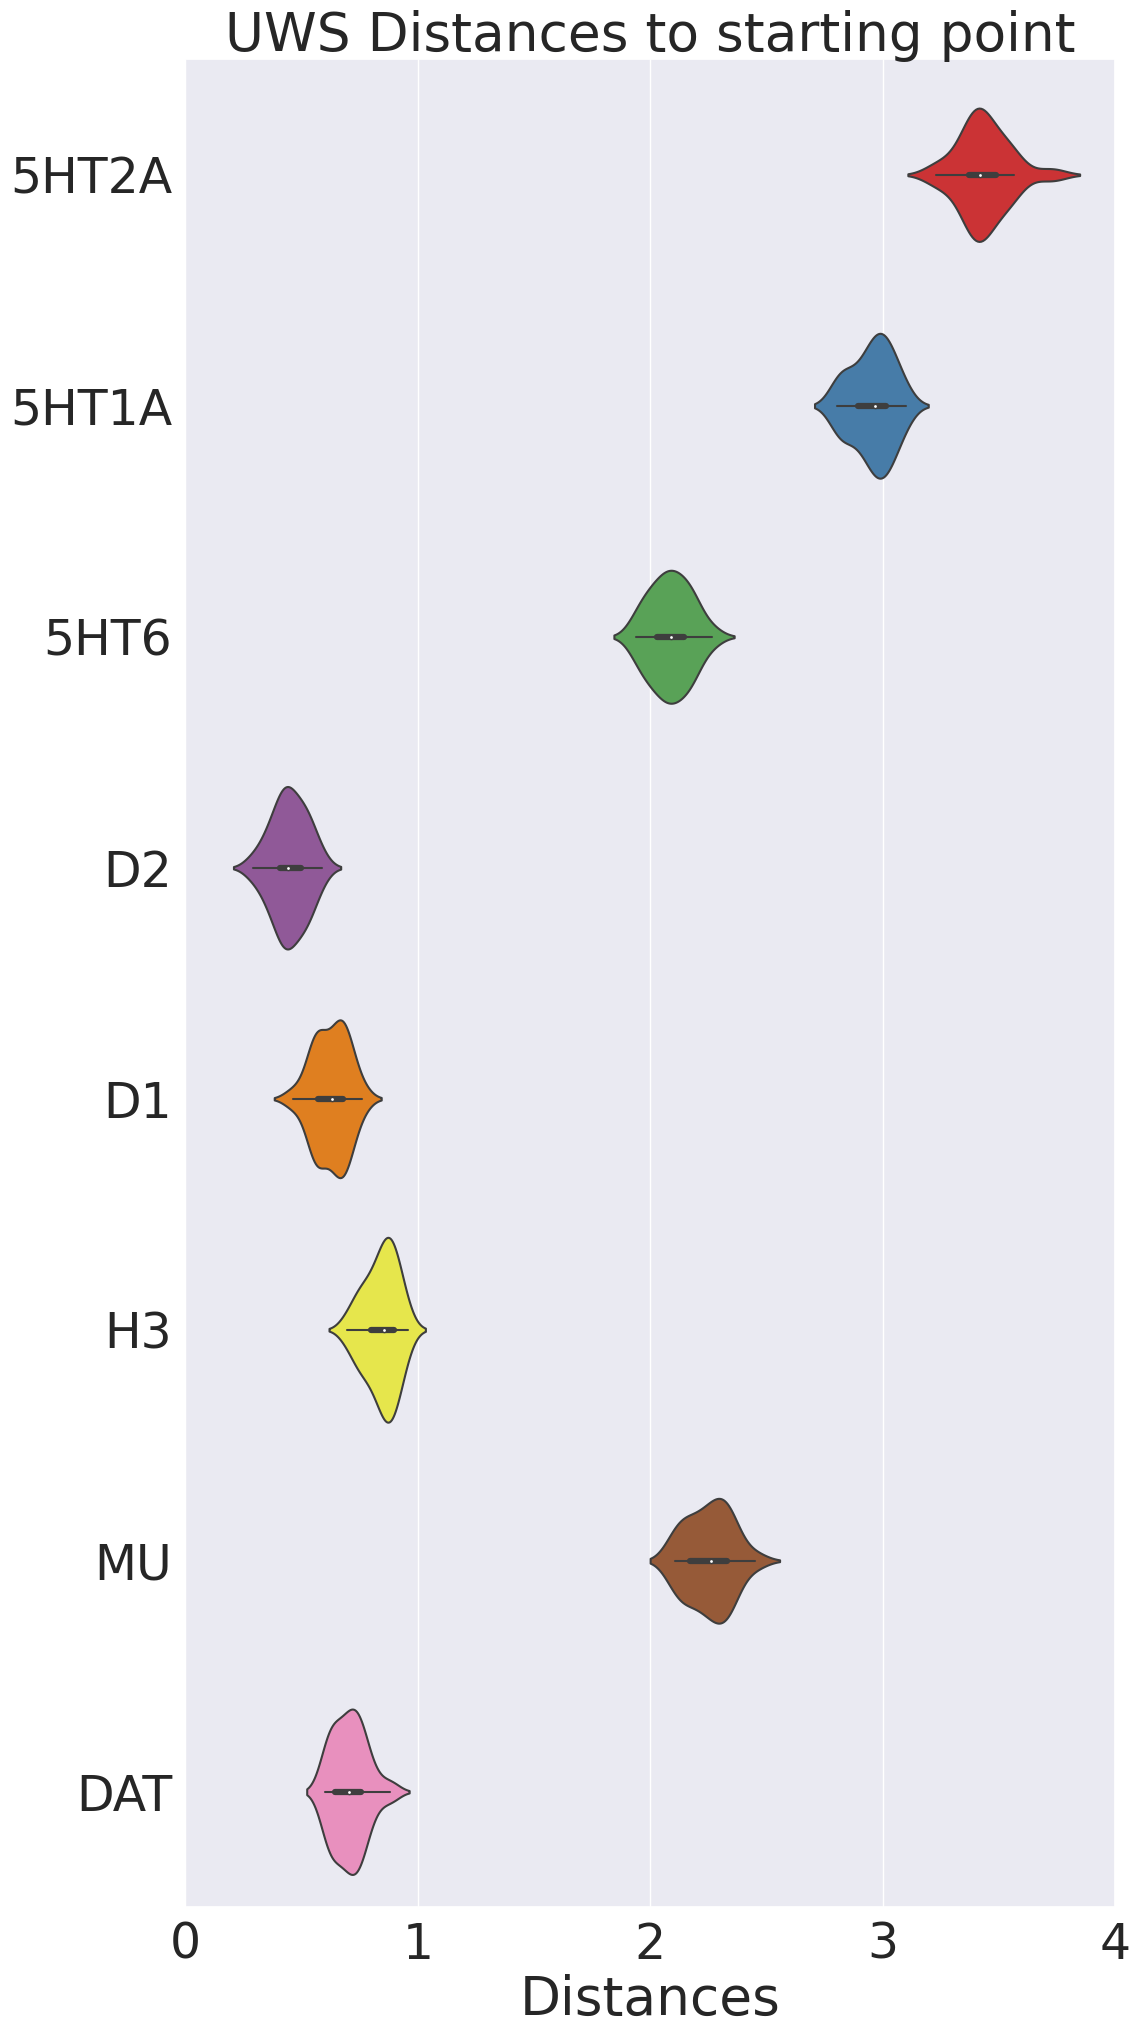

In [40]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib as mpl


# Define the scaling factor
scaling_factor = 2.4
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 5 * scaling_factor
font_size = 16 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

models = vae.get_layer('encoder'),vae.get_layer('decoder')

baseline_cmap = {2: 'CNT', 0: 'UWS', 1: 'MCS'}
# define the custom color palette
palette = sns.color_palette("viridis", n_colors=101)

baseline_colors = sns.color_palette('tab20', n_colors=3)
baseline_colors = [baseline_colors[1],baseline_colors[0],baseline_colors[2]]
encoder, decoder = models
x_check_test, y_test_check = x_test, y_test
# display a 2D plot of the FC classes in the latent space
z_mean, _, _ = encoder.predict([x_check_test,y_test_check], batch_size=batch_size)


cnt_centroid = np.mean(z_mean[y_test_check==0], axis=0)
uws_centroid = np.mean(z_mean[y_test_check==1], axis=0)
mcs_centroid = np.mean(z_mean[y_test_check==2], axis=0)
latent_centroids = np.array([uws_centroid,mcs_centroid,cnt_centroid])
latetnt_clusters = np.array([z_mean[y_test_check==1],z_mean[y_test_check==2],z_mean[y_test_check==0]])

BETA = np.arange(0,1.01,0.01)
# add the colorbar to the plo

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

#conditions = ['5HT2A', '5HT1A']
UWS_distances = np.zeros((20, len(conditions)))
UWS_maxidx = np.zeros((20, len(conditions)))
UWS_velocities = np.zeros((20, len(conditions),100)) # We dont take the velocity at time 0, so in total we have 100 points
condition_colors =sns.color_palette("Set1", n_colors=len(conditions))  
for idx,cond in enumerate(conditions):
    perturb_fcs = loadmat(f"/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/Results/FC_{cond}_UWS.mat")["FC_simul_all"]
    for rep in range(20):
        perturb_fcs_rep = perturb_fcs[rep, :, :,:] # Shape (rep, scale, nreg, nreg)
        z_perturb, _, _ = encoder.predict([np.reshape(perturb_fcs_rep,(101,90*90)),np.ones(shape=(101,))], batch_size=batch_size)        

        latent_dist = np.linalg.norm(z_perturb-cnt_centroid,axis=1)
        latent_dist = np.reshape(latent_dist, [101])
        #savemat(os.path.join(base_cluster,"Results",f"UWS_Wgain_{cond}", "latent_dist.mat"), {"latent_dist":latent_dist})
        UWS_distances[rep, idx] = (np.max(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        UWS_maxidx[rep, idx] = (np.argmax(np.linalg.norm(z_perturb-z_perturb[0],axis=1)))
        UWS_velocities[rep, idx, :] = calculate_distance_along_line(z_perturb[0, :],cnt_centroid,z_perturb)


data = UWS_distances
# Create the violin plot
fig, ax = plt.subplots(figsize=(fig_height,fig_width))
sns.violinplot(data,palette=condition_colors, showmedians=True, widths=0.7, showextrema=False, ax=ax, orient='h')

# Set custom colors for each category
for i, patch in enumerate(plt.gca().artists):
    patch.set_facecolor(condition_colors[i])

# Customize the plot
#plt.xticks(np.arange(len(conditions)), conditions, )
ax.set_yticklabels(conditions)
plt.xticks()
#legend_handles = [mpatches.Patch(facecolor=condition_colors[idx],alpha=0.8, label=conditions[idx]) for idx in range(len(conditions))]
#legend = plt.legend(handles=legend_handles, loc='center right')
#for lh in legend.legendHandles:
#    lh._sizes = [200]  # Adjust the marker size as needed
plt.xlim([0,4])
plt.xlabel('Distances')
plt.title('UWS Distances to starting point')
plt.savefig(f"plots/Figure4/UWS_DistanceToStart.png",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/UWS_DistanceToStart.svg",bbox_inches = 'tight')
# Display the plot
plt.show()

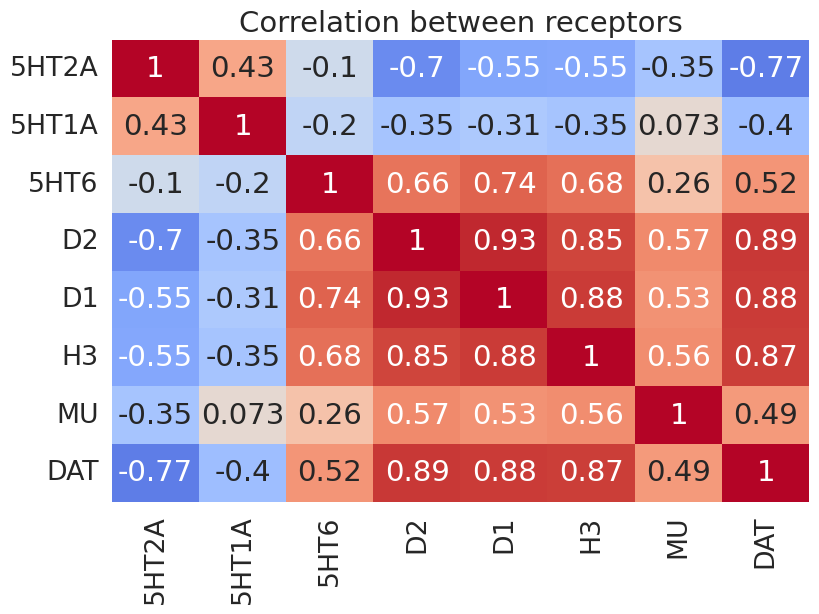

In [41]:
import pandas as pd
import seaborn as sns
from numpy import genfromtxt
receptors_mean = []
base_receptor_path = '/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/AAL'
conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']
receptor_fnames = [
    '5HT2a_cimbi_hc29_beliveau.csv',  
 '5HT1a_cumi_hc8_beliveau.csv',
 '5HT6_gsk_hc30_radhakrishnan.csv',
 'D2_flb457_hc37_smith.csv',     
 'D1_SCH23390_hc13_kaller.csv',       
    'H3_cban_hc8_gallezot.csv', 
 'MU_carfentanil_hc204_kantonen.csv',
 'DAT_fpcit_hc174_dukart_spect.csv']
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    receptors_mean.append(ratio)


# Define the scaling factor
scaling_factor = 1.5
# Apply the scaling factor to the original figure size and font size
fig_width = 6 * scaling_factor
fig_height = 4 * scaling_factor
font_size = 14 * scaling_factor

sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

receptor_data = np.squeeze(np.array(receptors_mean))
correlation_matrix = pd.DataFrame(receptor_data.T).corr(method='pearson')
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',cbar=False, center=0,cbar_kws={'ticks': []})
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, annot_kws={'size': 24}, cbar_kws={'ticks': []})
plt.xticks(np.arange(len(conditions)) + 0.5, conditions, rotation=90)
plt.yticks(np.arange(len(conditions)) + 0.5, conditions, rotation=0)
plt.title('Correlation between receptors')
plt.savefig(f"plots/Figure4/ReceptorCorr.svg",bbox_inches = 'tight')
plt.savefig(f"plots/Figure4/ReceptorCorr.png",bbox_inches = 'tight')
plt.show()


# Fig 5

In [42]:
from numpy import genfromtxt
from matplotlib.ticker import FuncFormatter

def format_ticks(value, pos):
    """
    Used to control the format of the ticks
    """
    return f'{value:.1f}'  # Format ticks as floats with 2 decimal places

receptors_mean_pets = []
base_receptor_path = '/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/AAL'

conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']

receptor_fnames = [
    '5HT2a_cimbi_hc29_beliveau.csv',  
 '5HT1a_cumi_hc8_beliveau.csv',
 '5HT6_gsk_hc30_radhakrishnan.csv',
 'D2_flb457_hc37_smith.csv',     
 'D1_SCH23390_hc13_kaller.csv',       
    'H3_cban_hc8_gallezot.csv', 
 'MU_carfentanil_hc204_kantonen.csv',
 'DAT_fpcit_hc174_dukart_spect.csv']
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    receptors_mean_pets.append(np.mean(ratio))

In [43]:
from numpy import genfromtxt
from scipy.stats import pearsonr
SC = loadmat("/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/ts_coma24_AAL_symm_withSC.mat")['SC']
weight_SC = np.mean(SC,axis=1)
weighted_receptors_mean_pets = []
base_receptor_path = '/network/lustre/iss02/cohen/data/Ivan/DMF_Gus/AAL'
conditions = ['5HT2A', '5HT1A','5HT6','D2', 'D1', 'H3', 'MU','DAT']
receptor_fnames = [
    '5HT2a_cimbi_hc29_beliveau.csv',  
 '5HT1a_cumi_hc8_beliveau.csv',
 '5HT6_gsk_hc30_radhakrishnan.csv',
 'D2_flb457_hc37_smith.csv',     
 'D1_SCH23390_hc13_kaller.csv',       
    'H3_cban_hc8_gallezot.csv', 
 'MU_carfentanil_hc204_kantonen.csv',
 'DAT_fpcit_hc174_dukart_spect.csv']


receptors = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    receptors.append(ratio)

receptor_density  = np.mean(np.array(ratio), axis=1)
weight_vector = weight_SC

receptor_min = np.min(receptor_density)
receptor_max = np.max(receptor_density)

# Step 2: Determine min and max values of weight vector
weight_min = np.min(weight_vector)
weight_max = np.max(weight_vector)

# Step 3: Rescale weight vector
rescaled_weight_vector = ((weight_vector - weight_min) / (weight_max - weight_min)) * (receptor_max - receptor_min) + receptor_min

myelin = loadmat("./data/myelin_aal.mat")['av']

myelin_vector = np.squeeze(myelin)
# Step 2: Determine min and max values of myelin vector
myelin_min = np.min(myelin_vector)
myelin_max = np.max(myelin_vector)
rescaled_myelin_vector = ((myelin_vector - myelin_min) / (myelin_max - myelin_min)) * (receptor_max - receptor_min) + receptor_min

weight_density_corrs = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    c,p = pearsonr(np.squeeze(ratio), rescaled_weight_vector)
    receptor_tag = receptor_fname.split("_")[0]
    #print(f"Correlation with Weight for {receptor_tag}\nCorr: {c:.2f} - P-value: {p:.4f}")
    weight_density_corrs.append(c)



weight_density_distance = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    c,p = pearsonr(np.squeeze(ratio), rescaled_weight_vector)
    receptor_tag = receptor_fname.split("_")[0]
    #print(f"Correlation with Weight for {receptor_tag}\nCorr: {c:.2f} - P-value: {p:.4f}")
    weight_density_distance.append(np.linalg.norm(np.squeeze(ratio)-rescaled_weight_vector))

myelin_density_distance = []
for receptor_fname in receptor_fnames:
    gen = genfromtxt(os.path.join(base_receptor_path,receptor_fname), delimiter=',')
    gen = gen[:90]
    gensym = np.zeros(90)
    gensym[:45] = gen[:90:2]
    gensym[89:44:-1] = gen[1:90:2]
    ratio = gensym.reshape(-1, 1)
    ratio = (ratio - np.min(ratio)) / (np.max(ratio) - np.min(ratio))
    ratio = ratio - np.max(ratio) + 1
    ratio[ratio < 0] = 0
    c,p = pearsonr(np.squeeze(ratio), rescaled_myelin_vector)
    receptor_tag = receptor_fname.split("_")[0]
    #print(f"Correlation with myelin for {receptor_tag}\nCorr: {c:.2f} - P-value: {p:.4f}")
    myelin_density_distance.append(np.linalg.norm(np.squeeze(ratio)-rescaled_weight_vector))

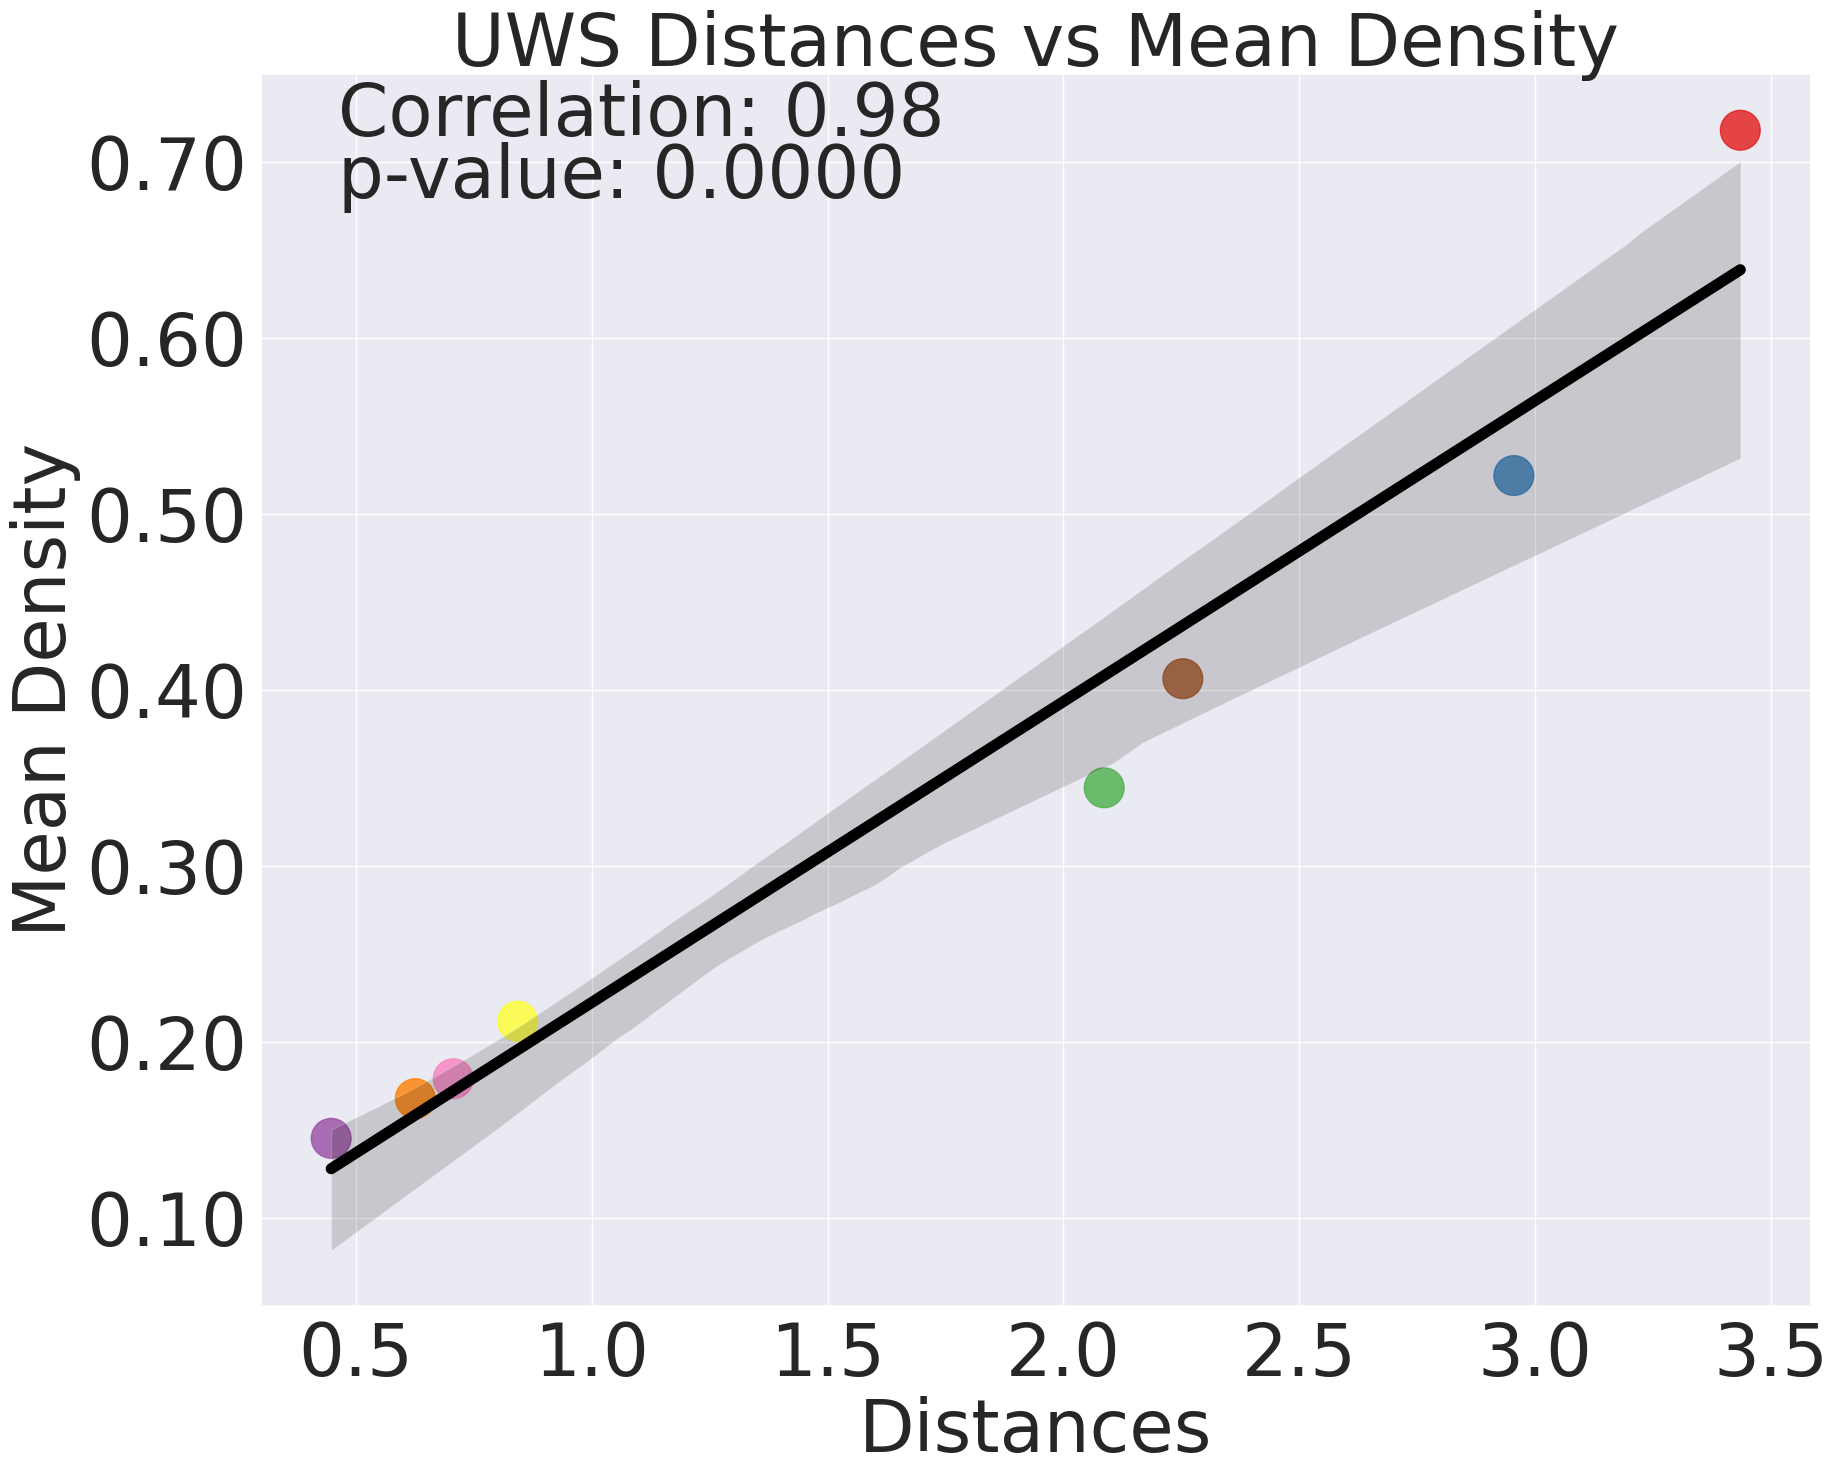

Correlation: 0.9770365930248571
p-value: 2.9753571896039607e-05


In [44]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

distances = np.mean(UWS_distances,axis=0)
mean_values = receptors_mean_pets

correlation, p_value = pearsonr(distances, mean_values)

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Mean Density', fontsize=font_size)
plt.title('UWS Distances vs Mean Density', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/UWS_DistanceVsDensity.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceVsDensity.png",bbox_inches = 'tight')
plt.show()
print("Correlation:", correlation)
print("p-value:", p_value)


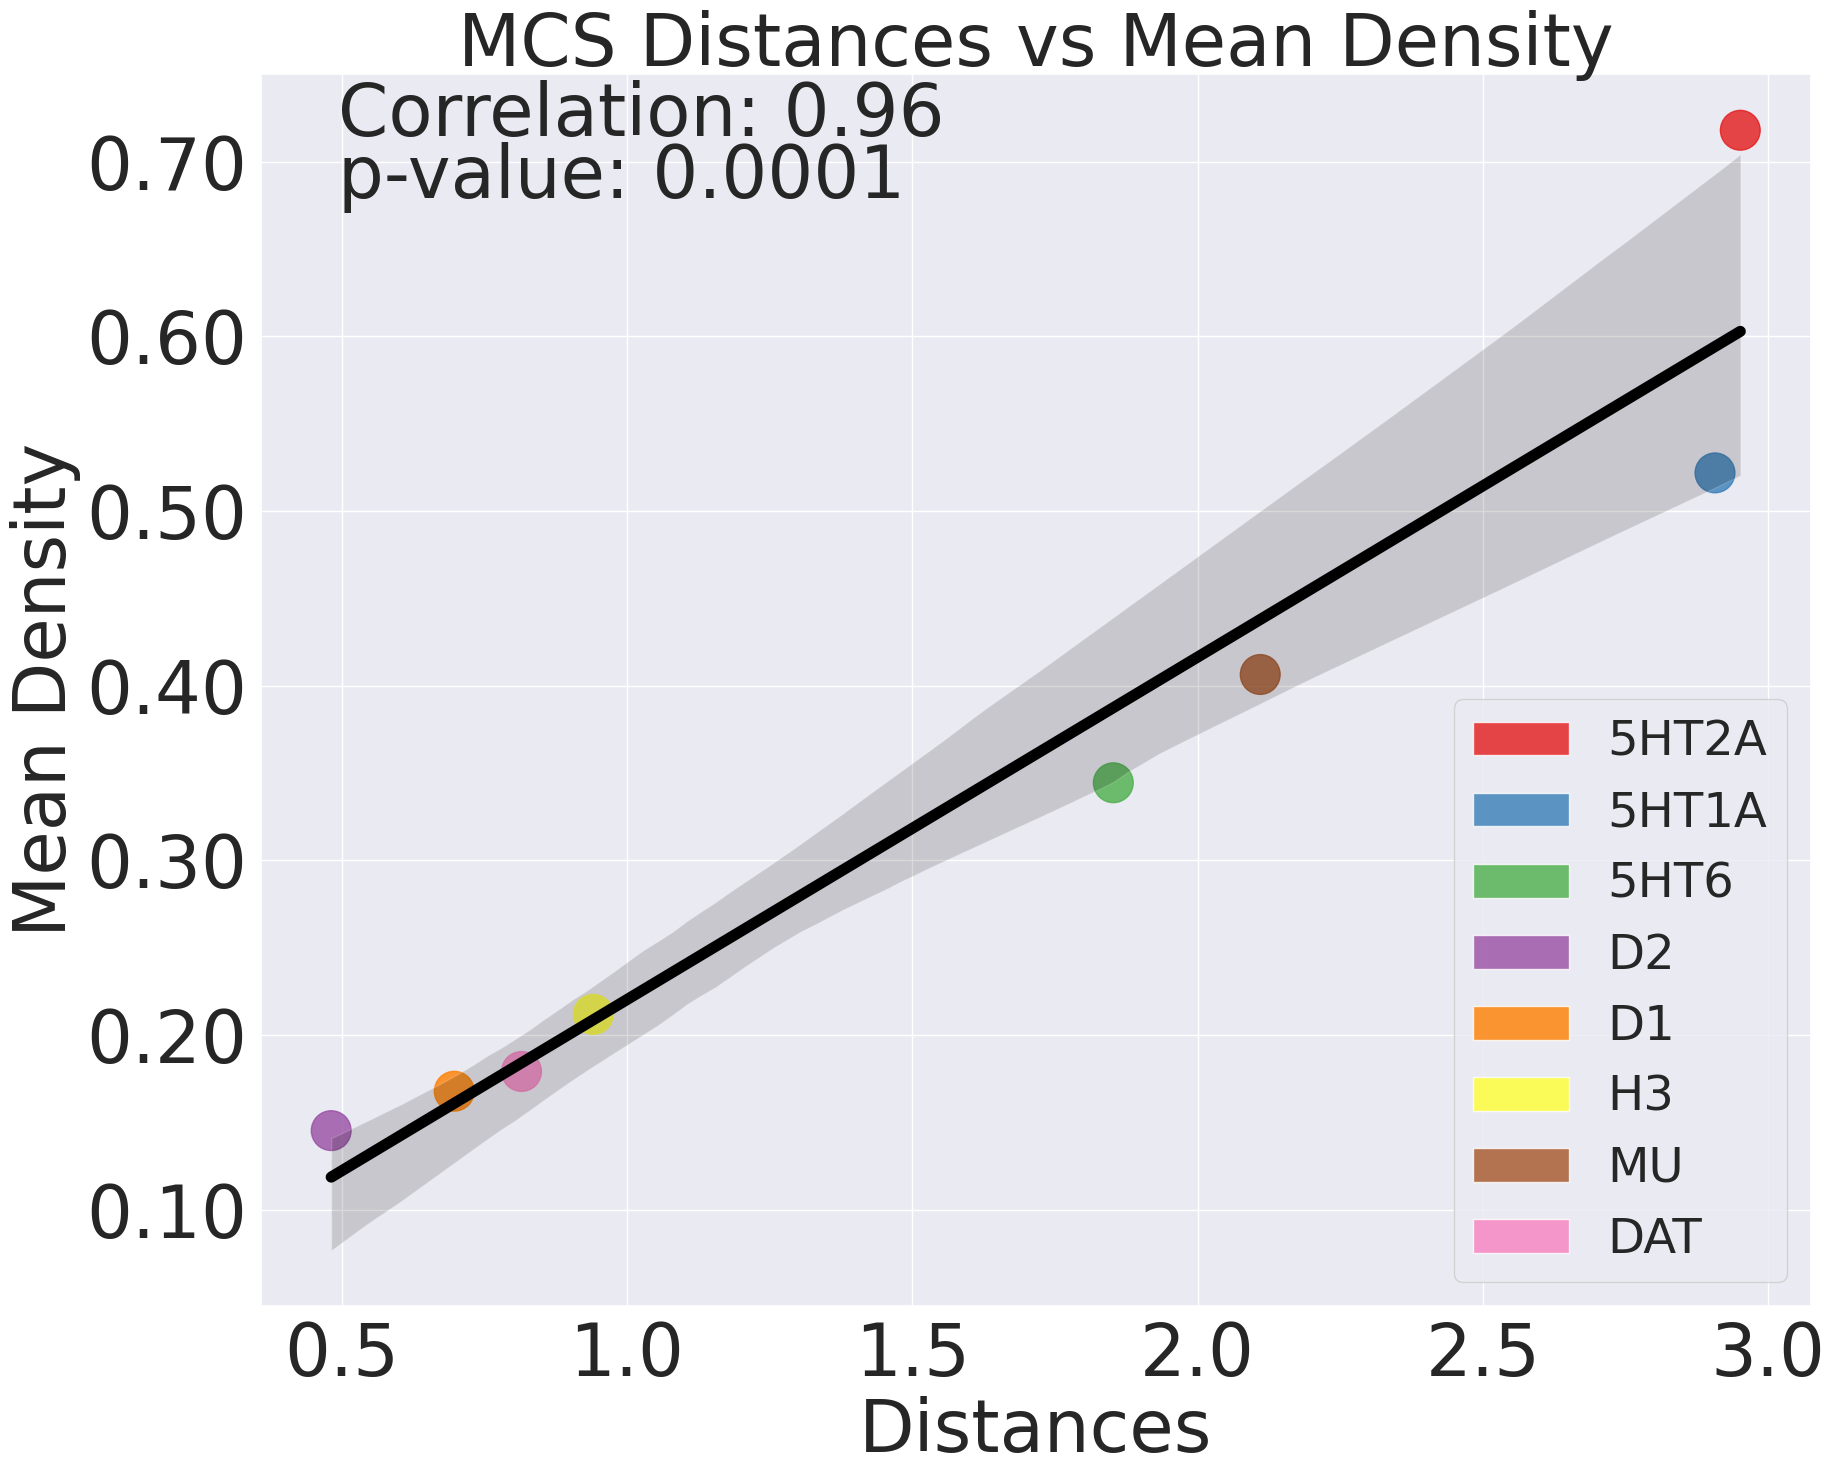

Correlation: 0.9611319660768561
p-value: 0.0001425511621608232


In [45]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor


distances = np.mean(MCS_distances,axis=0)
mean_values = receptors_mean_pets
correlation, p_value = pearsonr(distances, mean_values)
#fig, ax = plt.subplots(figsize=(10,9))
fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Mean Density', fontsize=font_size)
plt.title('MCS Distances vs Mean Density', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")


plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]

legend_handles = [mpatches.Patch(facecolor=condition_colors[idx],alpha=0.8, label=conditions[idx]) for idx in range(len(conditions))]
legend = plt.legend(handles=legend_handles, loc='center right')
for lh in legend.legendHandles:
    lh._sizes = [200]  # Adjust the marker size as needed

plt.legend(handles=legend_handles, loc="lower right", fontsize=font_size-(font_size/3))


plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/MCS_DistanceVsDensity.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceVsDensity.png",bbox_inches = 'tight')
plt.show()

print("Correlation:", correlation)
print("p-value:", p_value)


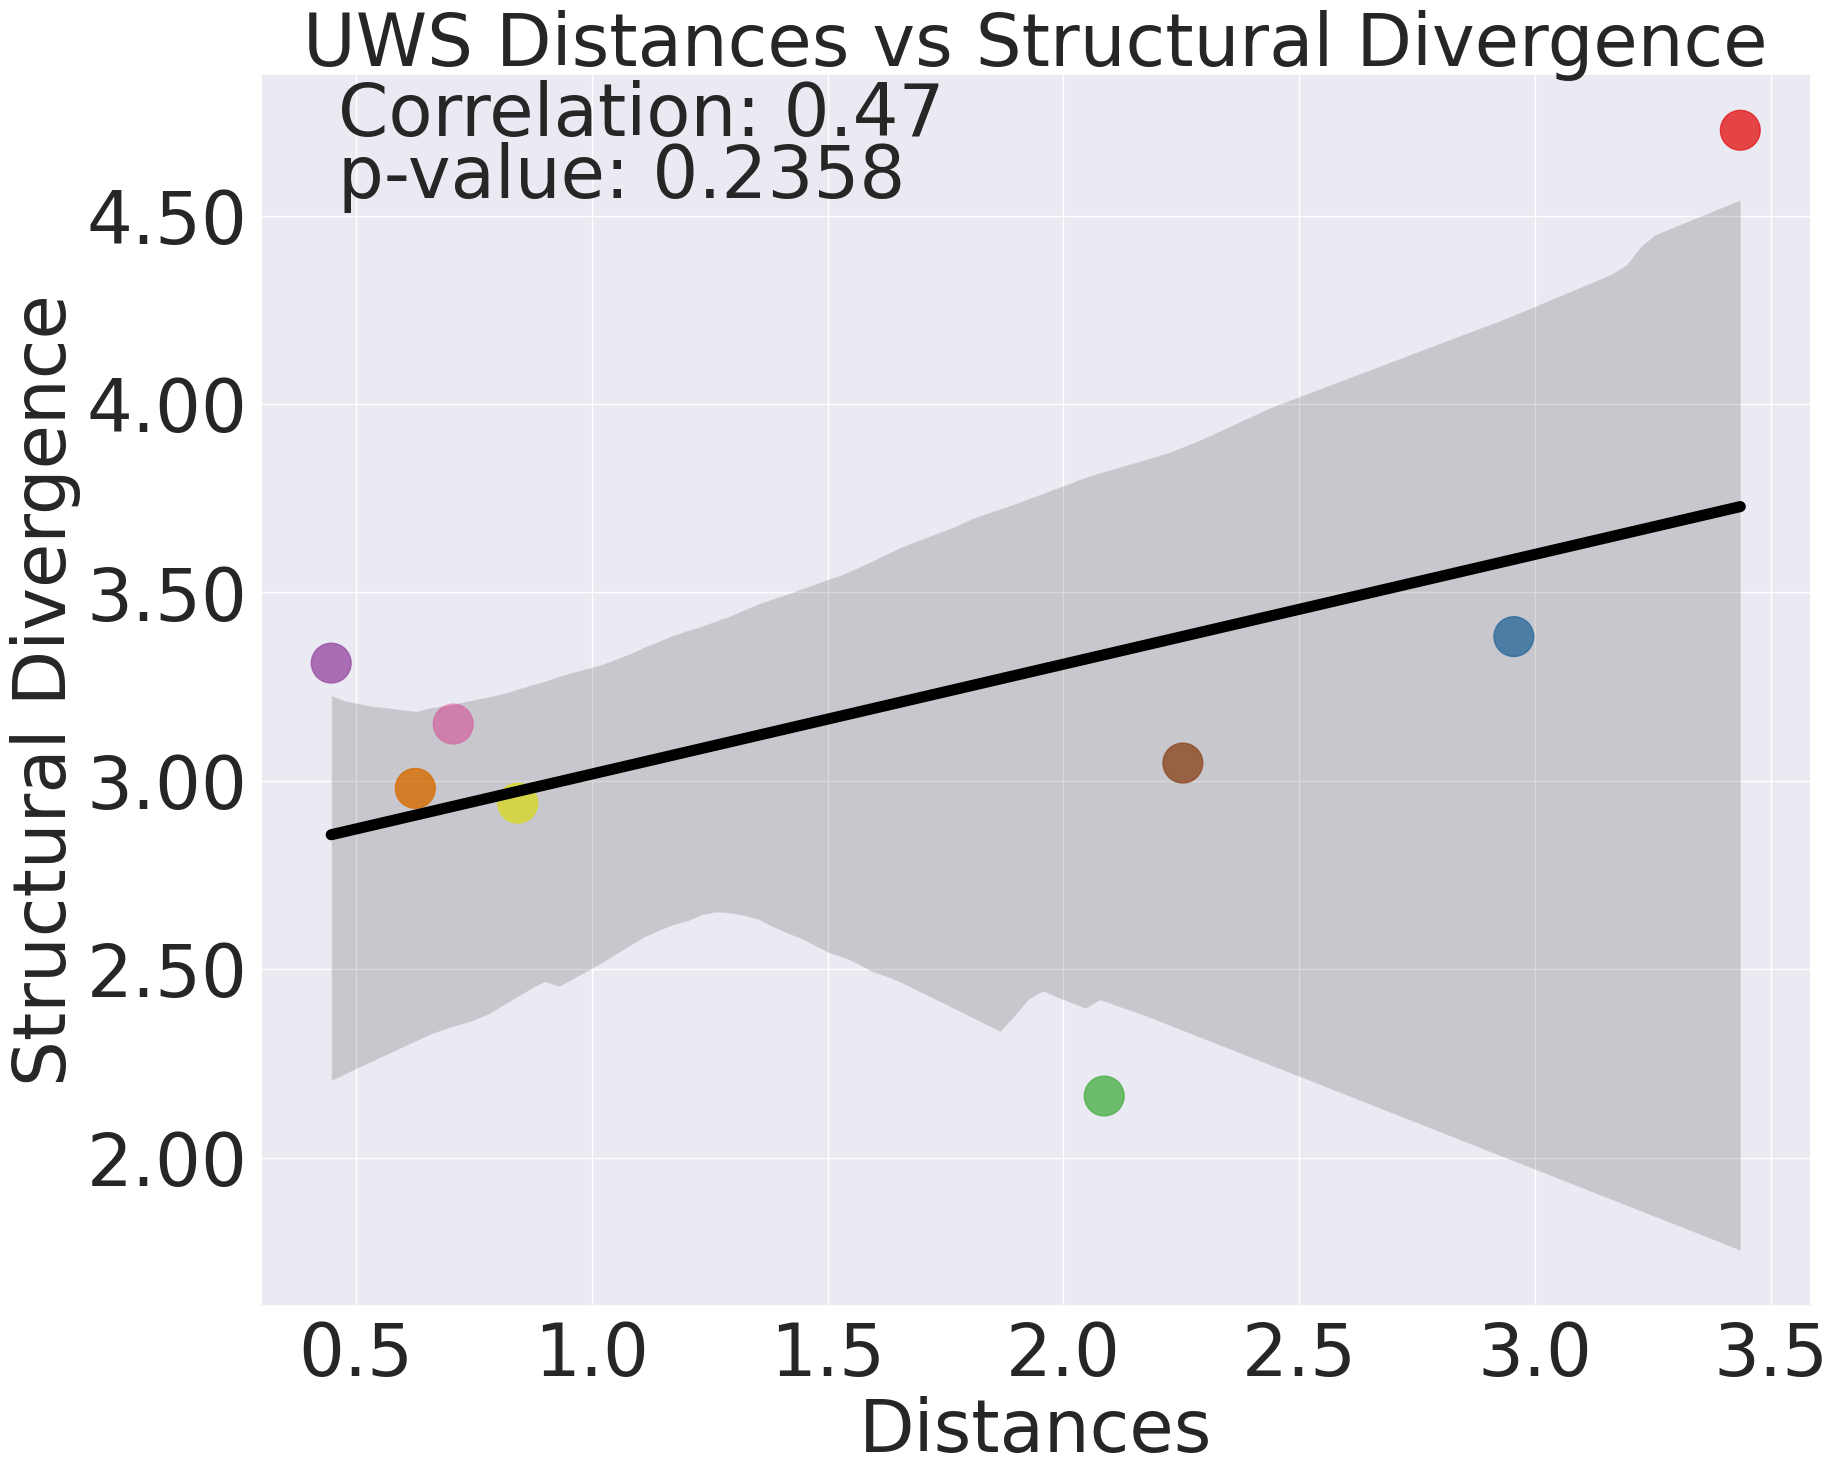

Correlation: 0.47359978784845924
p-value: 0.23584913884812025


In [46]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

distances = np.mean(UWS_distances,axis=0)
mean_values = weight_density_distance

correlation, p_value = pearsonr(distances, mean_values)

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Structural Divergence', fontsize=font_size)
plt.title('UWS Distances vs Structural Divergence', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/UWS_DistanceVsStructure.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceVsStructure.png", bbox_inches='tight')
plt.show()
print("Correlation:", correlation)
print("p-value:", p_value)


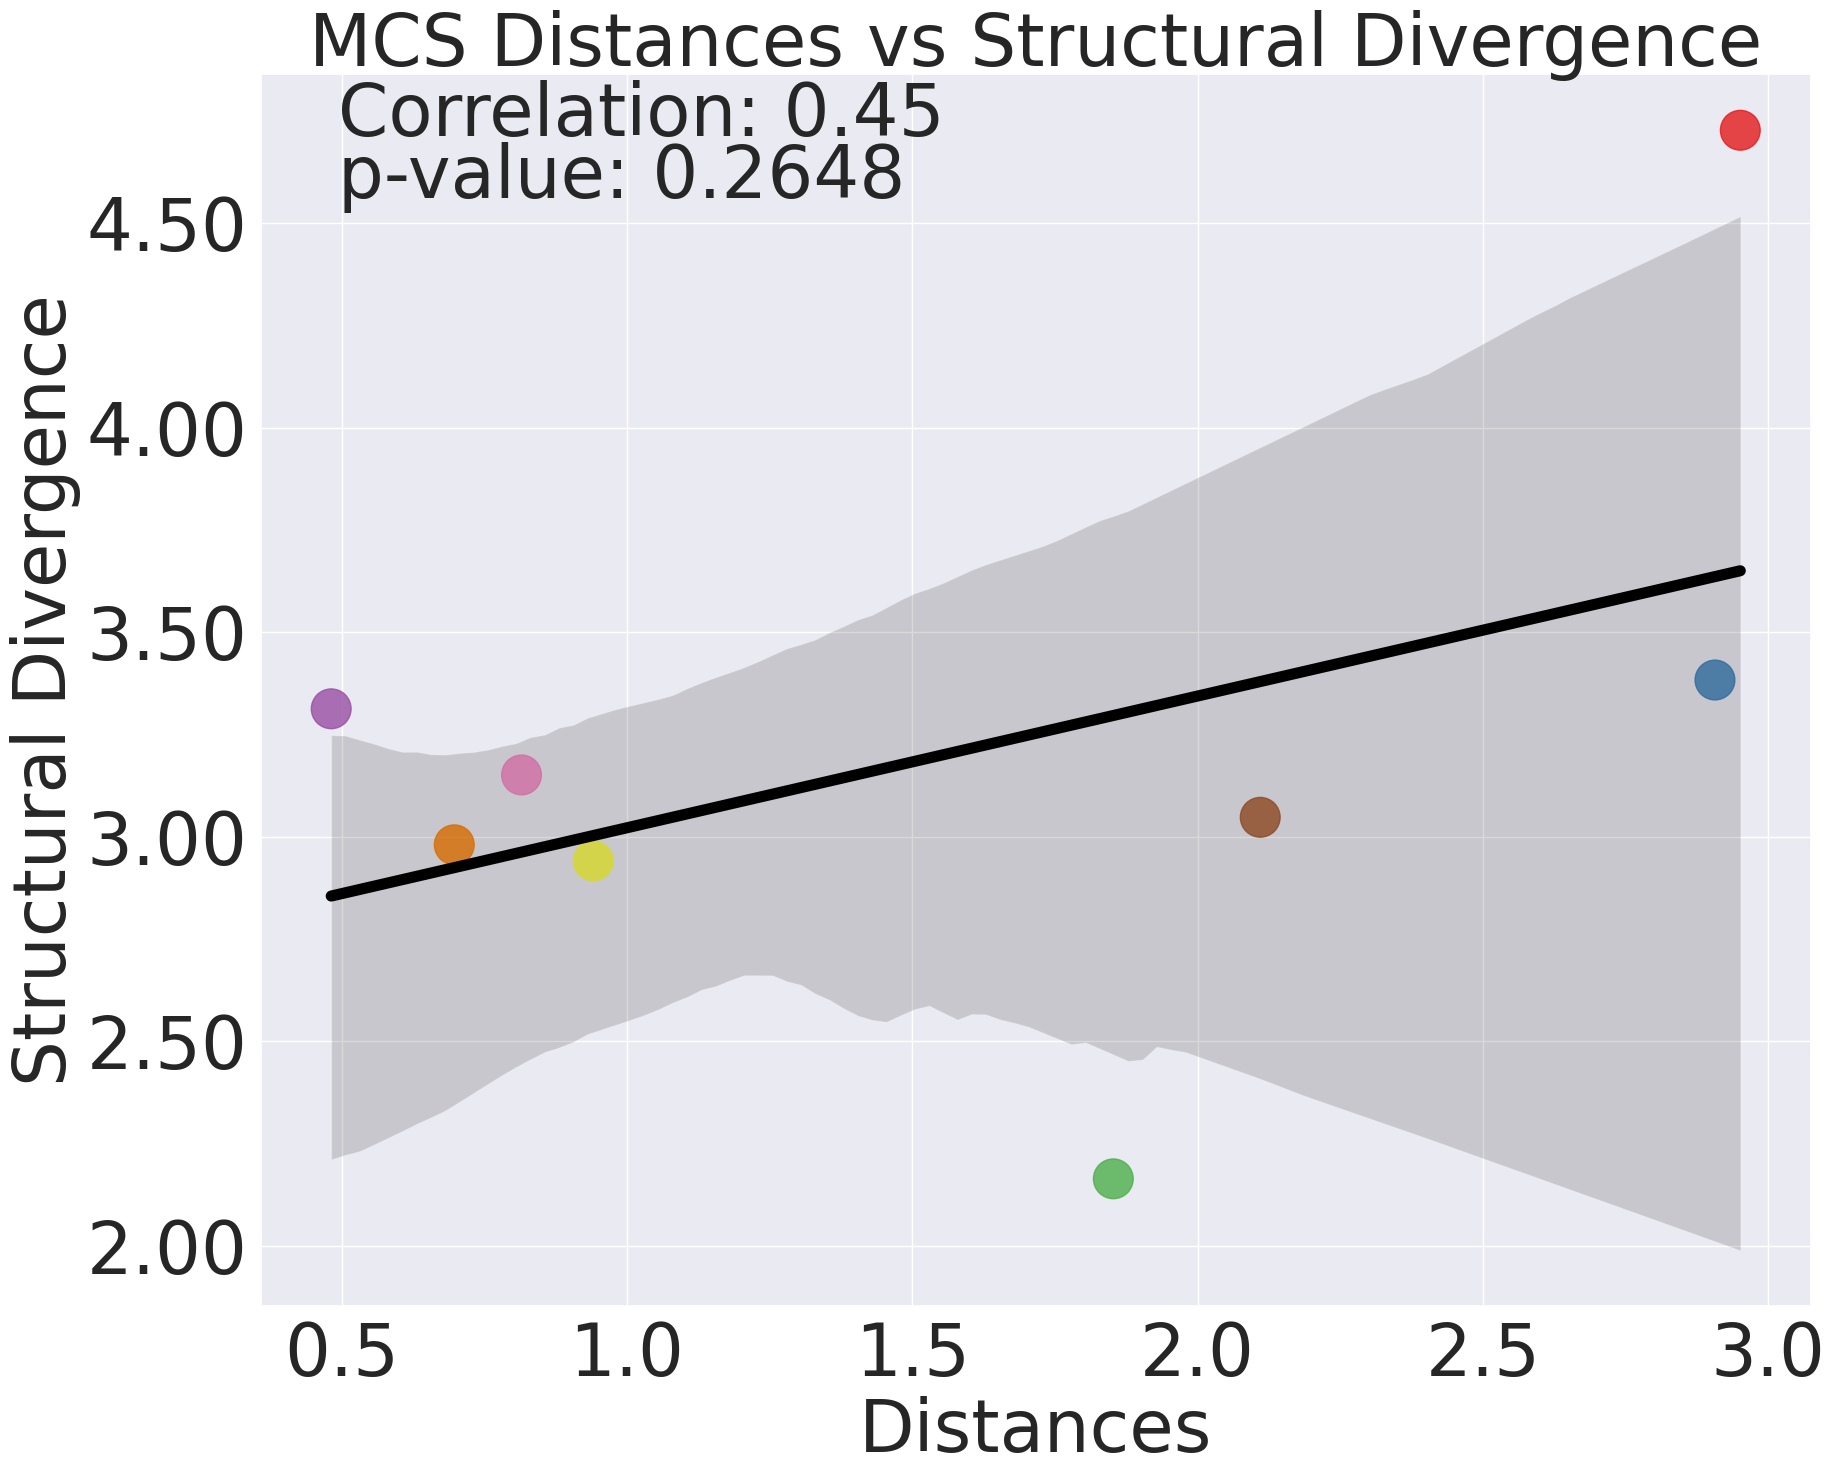

Correlation: 0.4486583504851699
p-value: 0.26483879933156734


In [47]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

fig, ax = plt.subplots(figsize=(fig_width,fig_height))

distances = np.mean(MCS_distances,axis=0)
mean_values = weight_density_distance
correlation, p_value = pearsonr(distances, mean_values)
#fig, ax = plt.subplots(figsize=(10,9))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'black'}, scatter_kws={'s':820,'color':condition_colors})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Structural Divergence', fontsize=font_size)
plt.title('MCS Distances vs Structural Divergence', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/MCS_DistanceVsStrcutre.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceVsStrcutre.png",bbox_inches = 'tight')
plt.show()

print("Correlation:", correlation)
print("p-value:", p_value)


### T1w:T2w

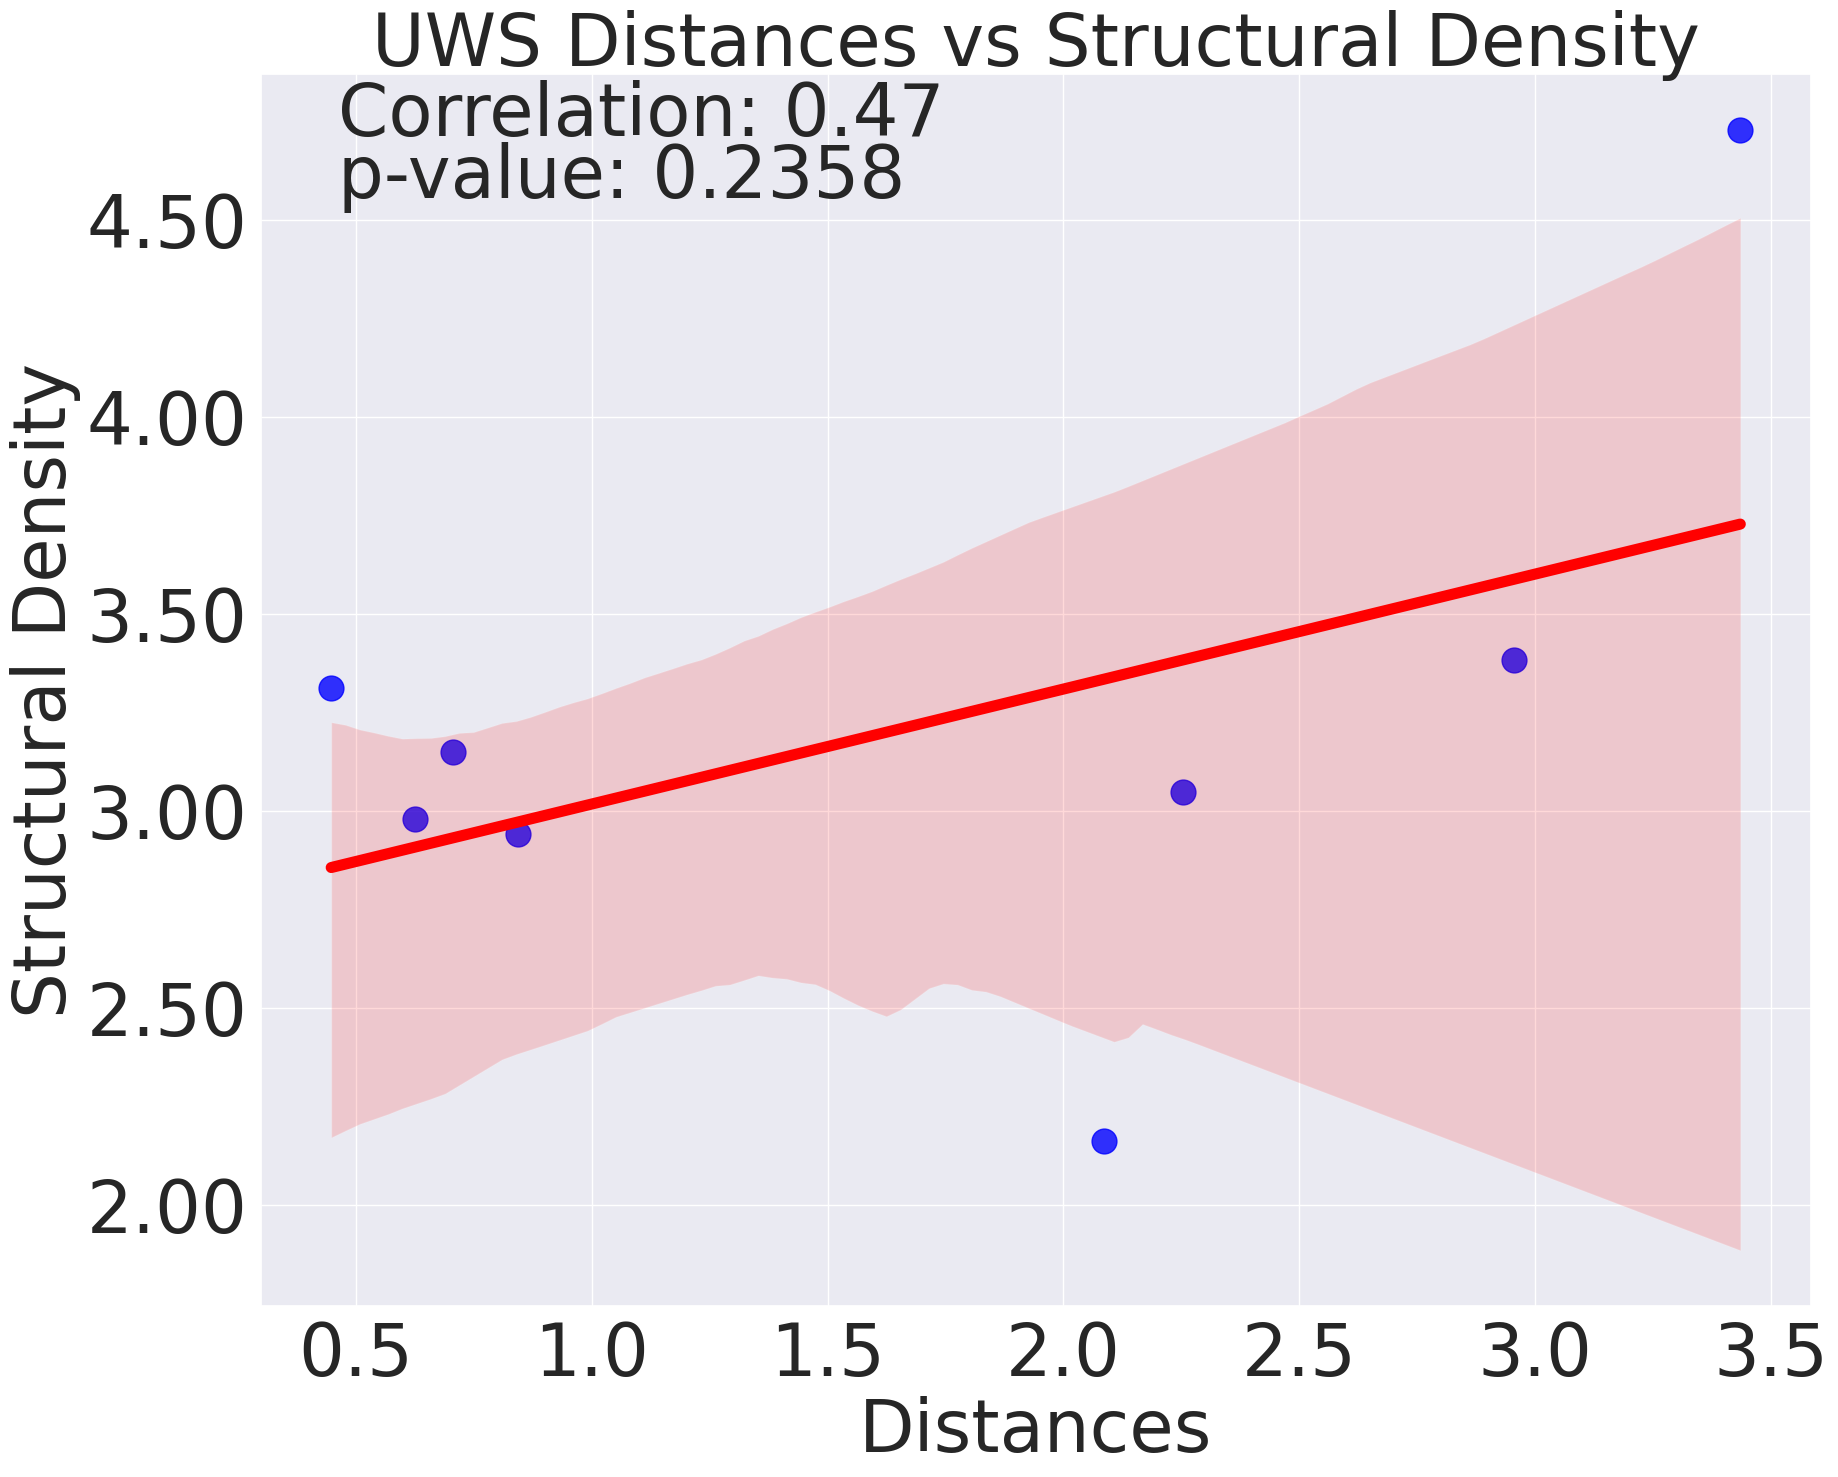

Correlation: 0.47359978784845924
p-value: 0.23584913884812025


In [48]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

distances = np.mean(UWS_distances,axis=0)
mean_values = myelin_density_distance

correlation, p_value = pearsonr(distances, mean_values)

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'red'}, scatter_kws={'s':320,'color':'blue'})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Structural Density', fontsize=font_size)
plt.title('UWS Distances vs Structural Density', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/UWS_DistanceVsMyelin.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceVsMyelin.png", bbox_inches='tight')
plt.show()
print("Correlation:", correlation)
print("p-value:", p_value)


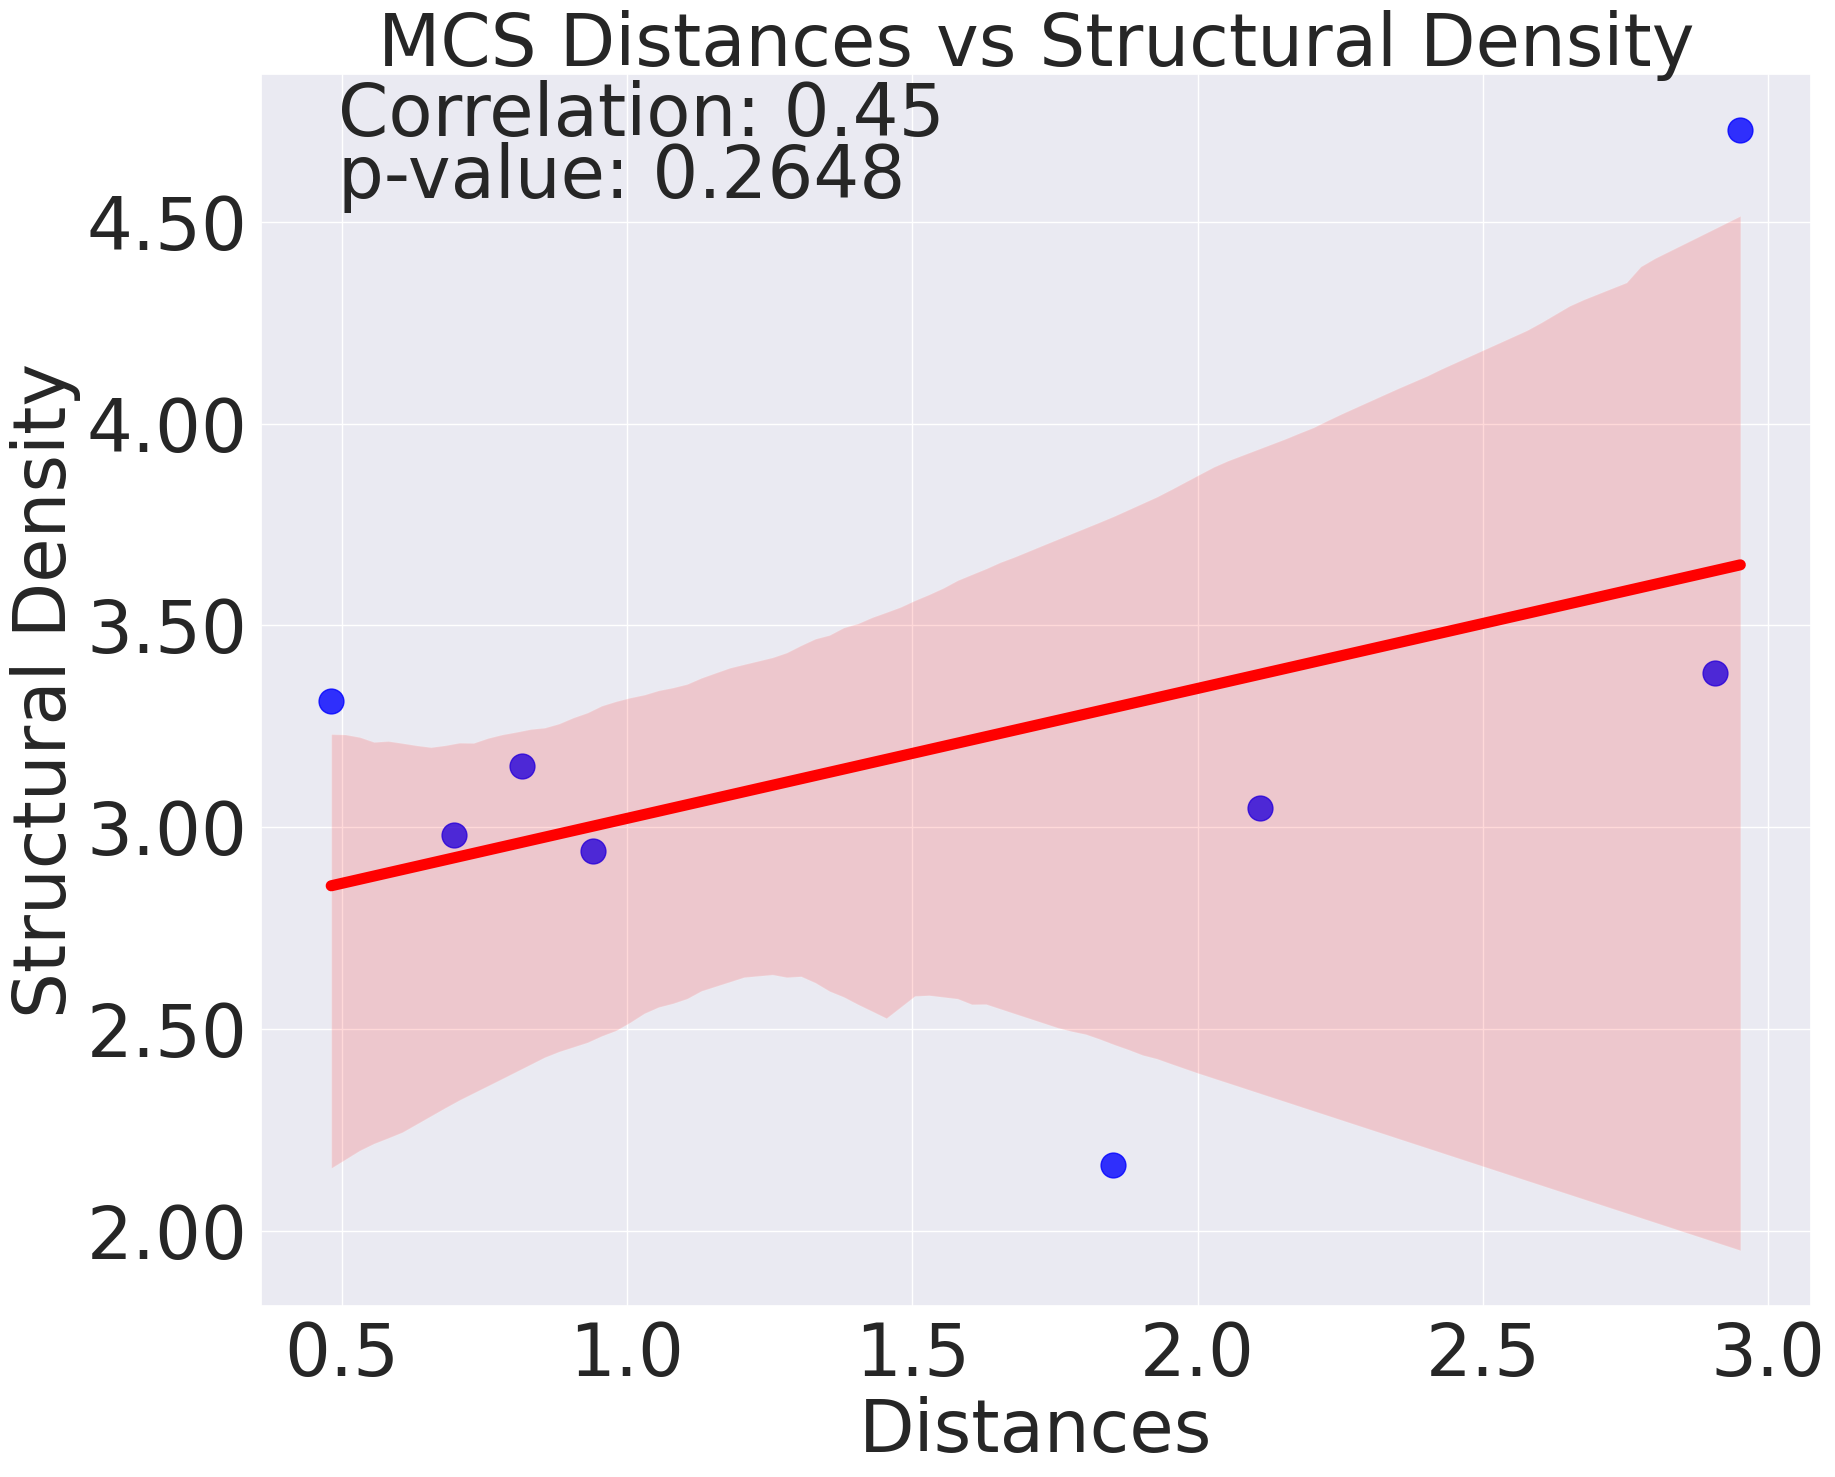

Correlation: 0.4486583504851699
p-value: 0.26483879933156734


In [49]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
# Define the scaling factor
scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

distances = np.mean(MCS_distances,axis=0)
mean_values = myelin_density_distance

correlation, p_value = pearsonr(distances, mean_values)

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.regplot(x=distances, y=mean_values, ci=95, line_kws={'linewidth':8,'color':'red'}, scatter_kws={'s':320,'color':'blue'})
plt.xlabel('Distances', fontsize=font_size)
plt.ylabel('Structural Density', fontsize=font_size)
plt.title('MCS Distances vs Structural Density', fontsize=font_size)
plt.annotate(f"Correlation: {correlation:.2f}", xy=(0.05, 0.95), xycoords='axes fraction', fontsize=font_size)
plt.annotate(f"p-value: {p_value:.4f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.savefig(f"plots/Figure5/MCS_DistanceVsMyelin.svg", bbox_inches='tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceVsMyelin.png", bbox_inches='tight')
plt.show()
print("Correlation:", correlation)
print("p-value:", p_value)


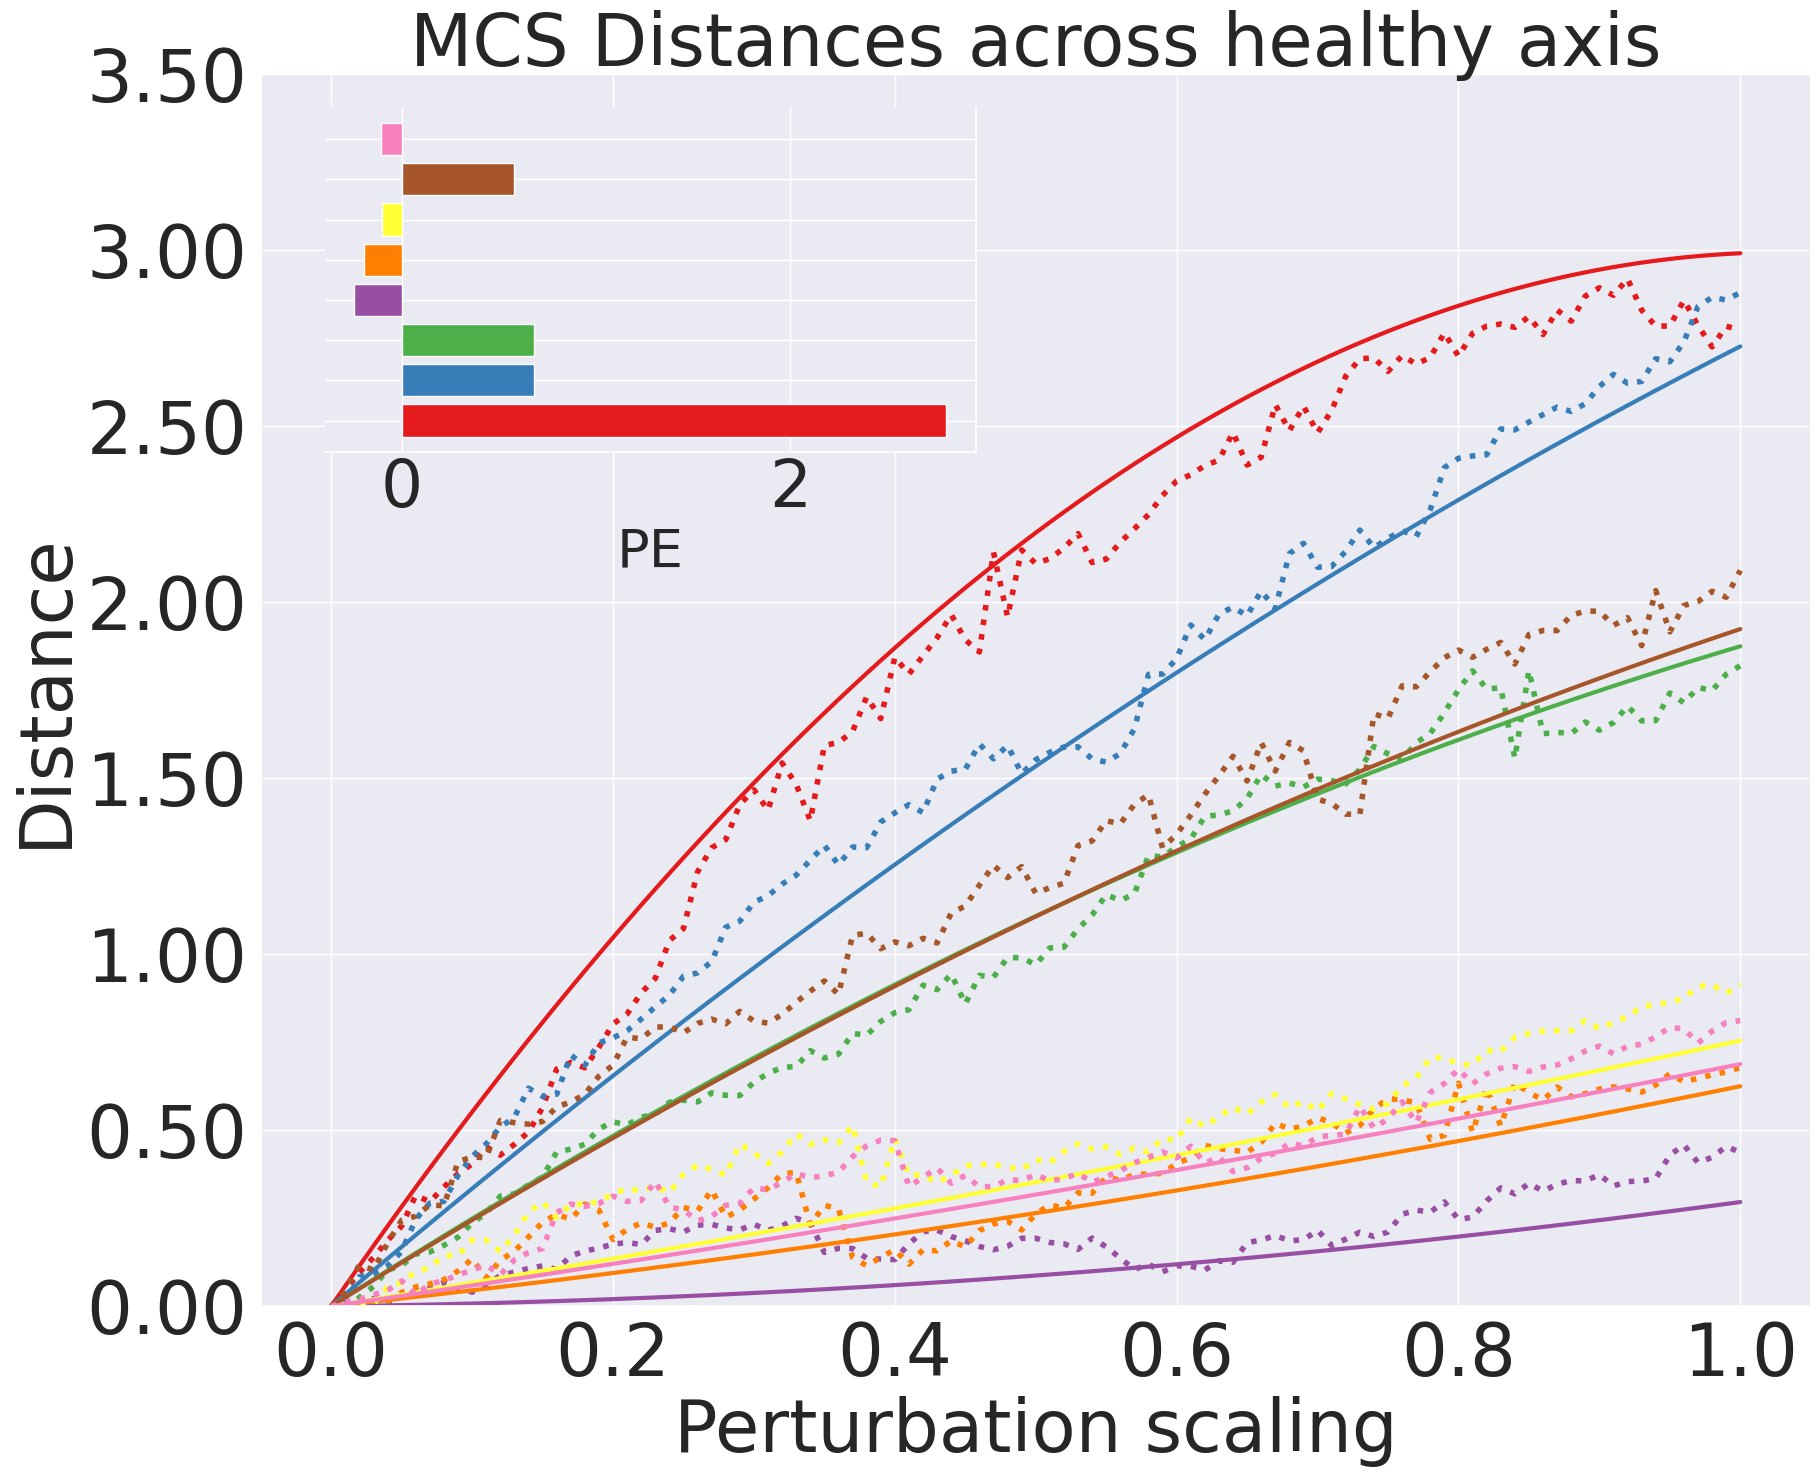

In [50]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,Bbox
def poly_func_3(x, a, b, c,d):
    return a * x**3 + b * x ** 2+ c * x + d  # You can adjust the degree of the polynomial
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c  # You can adjust the degree of the polynomial


scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

MCS_speed_curves = list(map(lambda inst_speeds: np.cumsum([0]+inst_speeds), np.mean(MCS_velocities,axis=0)))
MCS_speed_curves = [np.insert(subarray, 0, 0) for subarray in MCS_speed_curves]
perturb_scale = np.arange(0.0,1.01,0.01)
quad_coefficients = []
coeff_fits_MCS = []
for idx,curve in enumerate(MCS_speed_curves):
    popt, _ = curve_fit(poly_func, perturb_scale, curve)
    coeff_fits_MCS.append(popt)
    fitted_curve = poly_func(perturb_scale, *popt)
    fitted_curve-=fitted_curve[0]
    plt.plot(perturb_scale, curve, color=condition_colors[idx], linewidth=4, linestyle='dotted')
    plt.plot(perturb_scale, fitted_curve, color=condition_colors[idx], linewidth=3)
    quad_coeff = -1*popt[0]  # Assuming the quadratic term is the first coefficient
    quad_coefficients.append(quad_coeff)

plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]
plt.title("MCS Distances across healthy axis",fontsize=font_size)
ax.tick_params(labelsize=18)
# Add the legends to the plot
plt.xlabel("Perturbation scaling", fontsize=font_size)
plt.ylabel("Distance", fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylim([0,3.5])

bbox = Bbox.from_bounds(0.02, -0.40, 1.4, 1.4)
axins = inset_axes(ax, width="30%", height="20%", loc='upper left', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
axins.barh(np.arange(len(quad_coefficients)), quad_coefficients, color=condition_colors)
axins.set_yticks(np.arange(len(quad_coefficients)))
#axins.set_yticklabels([f'Condition {i+1}' for i in range(len(quad_coefficients))])
axins.set_yticklabels([])
axins.set_xlabel('PE', fontsize=39)
axins.spines['top'].set_visible(False)
axins.spines['left'].set_visible(False)
axins.tick_params(axis='both', which='both', length=0)

#plt.legend(handles=plot_legend_handles, loc="upper left", fontsize=font_size-(font_size/5))
plt.savefig(f"plots/Figure5/MCS_DistanceWithScaling.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/MCS_DistanceWithScaling.png",bbox_inches = 'tight')

In [51]:
popt

array([0.10707314, 0.58076245, 0.08458741])

/home/ivan.mindlin/anaconda3/envs/vae_clone/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator


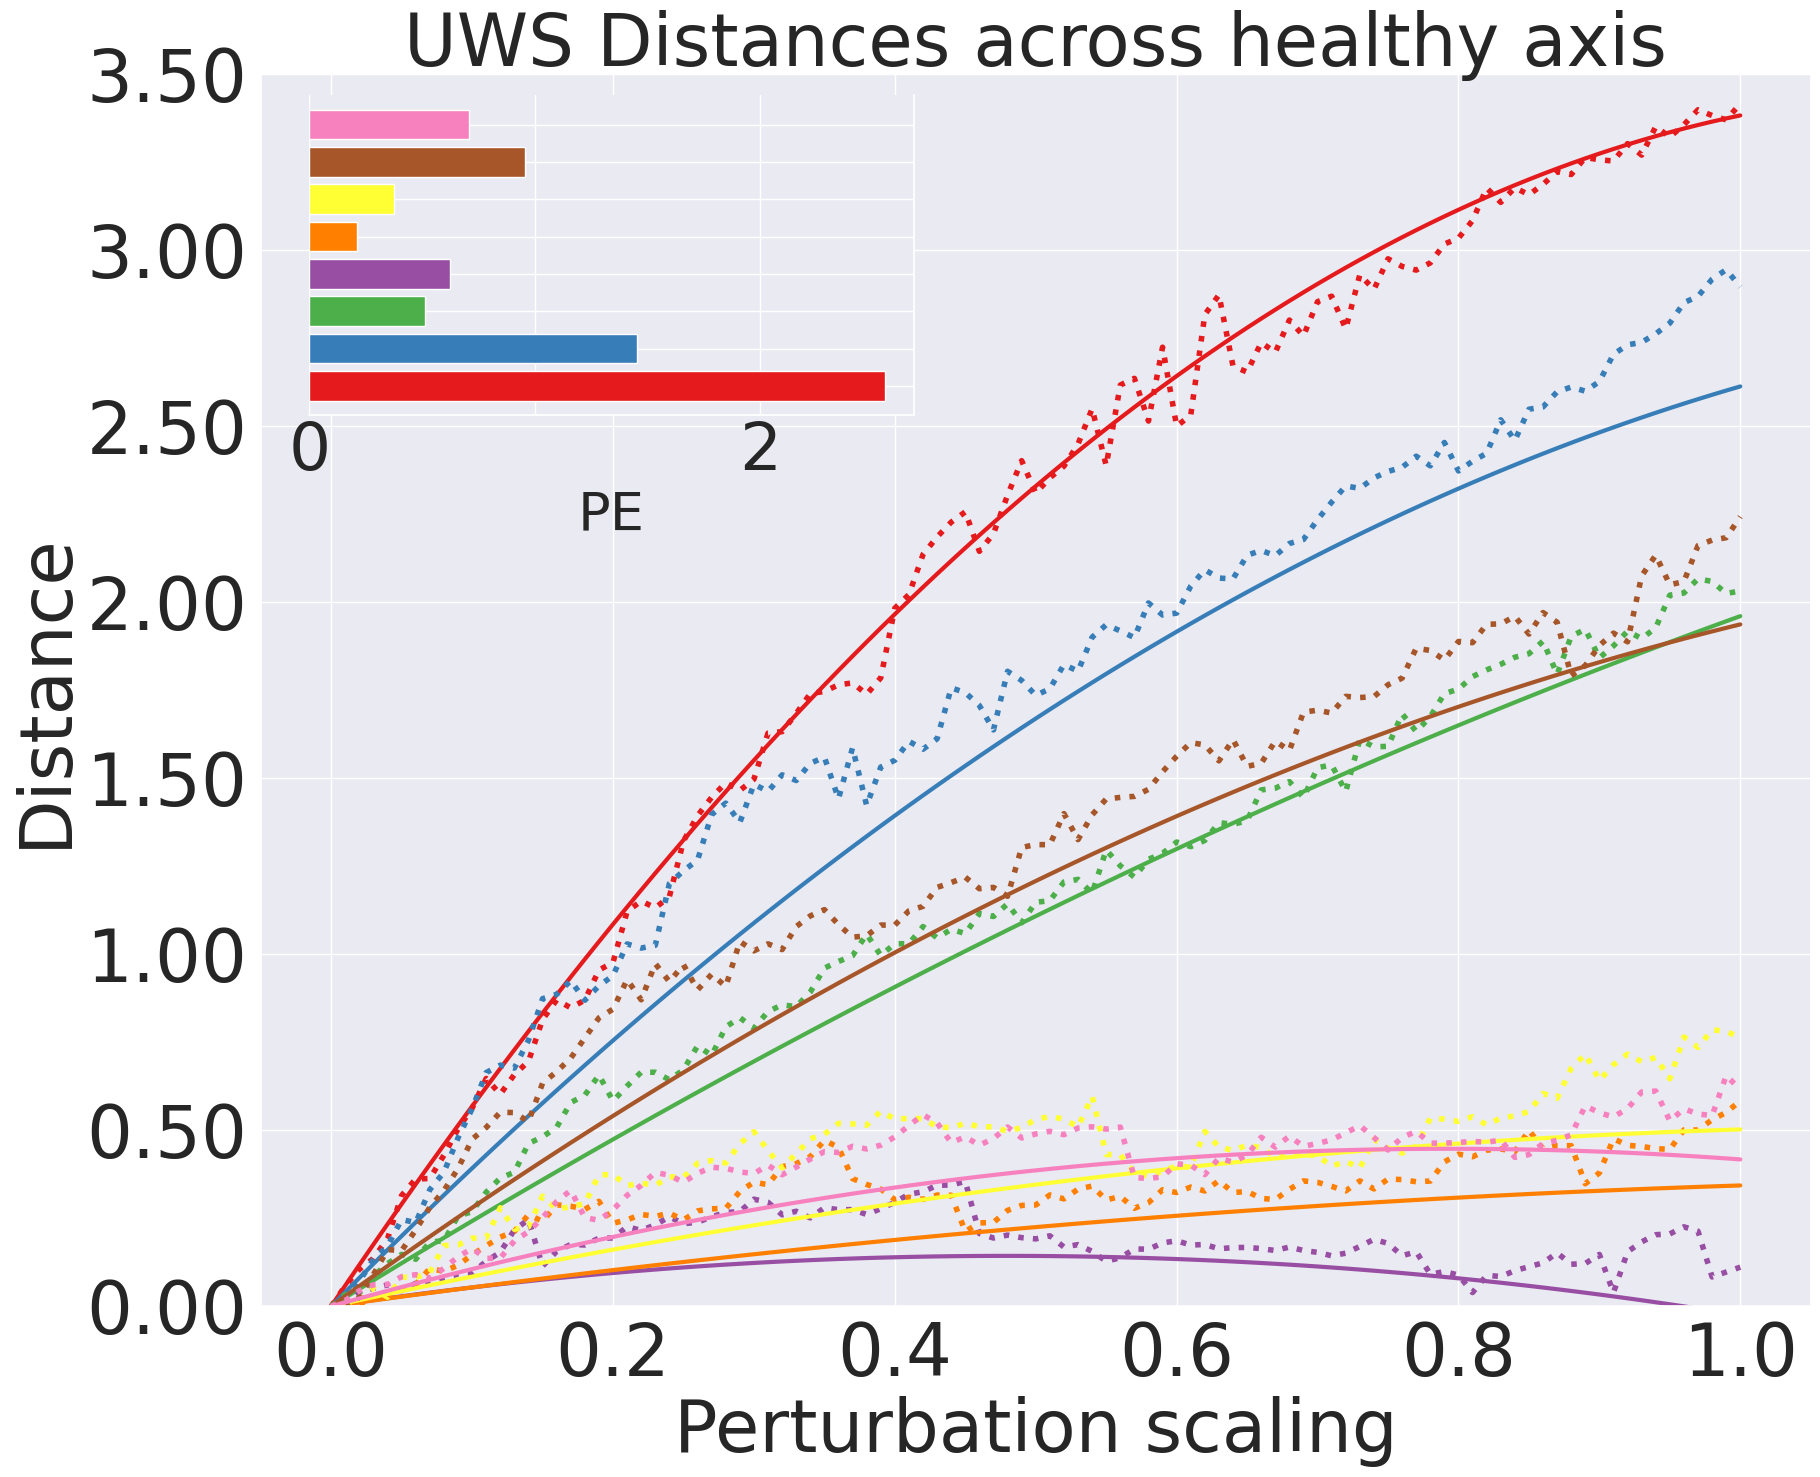

In [52]:
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1.inset_locator import inset_axes,Bbox
def poly_func_3(x, a, b, c,d):
    return a * x**3 + b * x ** 2+ c * x + d  # You can adjust the degree of the polynomial
def poly_func(x, a, b, c):
    return a * x**2 + b * x + c  # You can adjust the degree of the polynomial


scaling_factor = 2
# Apply the scaling factor to the original figure size and font size
fig_width = 10 * scaling_factor
fig_height = 8 * scaling_factor
font_size = 26 * scaling_factor

fig, ax = plt.subplots(figsize=(fig_width,fig_height))
sns.set(style="darkgrid", font_scale=font_size / 12)  # Adjust font_scale

UWS_speed_curves = list(map(lambda inst_speeds: np.cumsum([0]+inst_speeds), np.mean(UWS_velocities,axis=0)))
UWS_speed_curves = [np.insert(subarray, 0, 0) for subarray in UWS_speed_curves]
perturb_scale = np.arange(0.0,1.01,0.01)
quad_coefficients = []
coeff_fits_UWS = []
for idx,curve in enumerate(UWS_speed_curves):
    popt, _ = curve_fit(poly_func, perturb_scale, curve)
    coeff_fits_UWS.append(popt)
    fitted_curve = poly_func(perturb_scale, *popt)
    fitted_curve-=fitted_curve[0]
    plt.plot(perturb_scale, curve, color=condition_colors[idx], linewidth=4, linestyle='dotted')
    plt.plot(perturb_scale, fitted_curve, color=condition_colors[idx], linewidth=3)
    quad_coeff = -1*popt[0]  # Assuming the quadratic term is the first coefficient
    quad_coefficients.append(quad_coeff)

plot_legend_handles = [mlines.Line2D([], [], color=condition_colors[idx], label=conditions[idx]) for idx in range(len(conditions))]
plt.title("UWS Distances across healthy axis",fontsize=font_size)
ax.tick_params(labelsize=18)
# Add the legends to the plot
plt.xlabel("Perturbation scaling", fontsize=font_size)
plt.ylabel("Distance", fontsize=font_size)
x_formatter = ticker.FuncFormatter(lambda x, _: f"{x:.1f}")
y_formatter = ticker.FuncFormatter(lambda y, _: f"{y:.2f}")
plt.gca().xaxis.set_major_formatter(FuncFormatter(x_formatter))
plt.gca().yaxis.set_major_formatter(FuncFormatter(y_formatter))
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)
plt.ylim([0,3.5])

bbox = Bbox.from_bounds(0.01, -0.29, 1.3, 1.3)
axins = inset_axes(ax, width="30%", height="20%", loc='upper left', bbox_to_anchor=bbox, bbox_transform=ax.transAxes)
axins.barh(np.arange(len(quad_coefficients)), quad_coefficients, color=condition_colors)
axins.set_yticks(np.arange(len(quad_coefficients)))
#axins.set_yticklabels([f'Condition {i+1}' for i in range(len(quad_coefficients))])
axins.set_yticklabels([])
axins.set_xticklabels(['0','','2'])
axins.set_xlabel('PE', fontsize=39)
axins.spines['top'].set_visible(False)
axins.spines['left'].set_visible(False)
axins.tick_params(axis='both', which='both', length=0)

#plt.legend(handles=plot_legend_handles, loc="upper left", fontsize=font_size-(font_size/5))
plt.savefig(f"plots/Figure5/UWS_DistanceWithScaling.svg",bbox_inches = 'tight', format='svg')
plt.savefig(f"plots/Figure5/UWS_DistanceWithScaling.png",bbox_inches = 'tight')

In [82]:
coeff_fits_MCS

[array([-2.80694463,  5.7984585 , -0.12809671]),
 array([-0.6828144 ,  3.40971102,  0.08139777]),
 array([-0.68258103,  2.55751196, -0.02428292]),
 array([0.2431865 , 0.0528872 , 0.09125677]),
 array([0.19161452, 0.43345559, 0.07108223]),
 array([0.09875131, 0.65579775, 0.11498271]),
 array([-0.58122974,  2.50508929,  0.13724641]),
 array([0.10707314, 0.58076245, 0.08458741])]

In [83]:
coeff_fits_UWS

[array([-2.55344799,  5.93648624, -0.02385788]),
 array([-1.45206374,  4.0652079 ,  0.16474563]),
 array([-0.51166465,  2.47226966,  0.07385413]),
 array([-0.6219276 ,  0.59669465,  0.08391515]),
 array([-0.21310551,  0.55627086,  0.10872819]),
 array([-0.37728308,  0.87960741,  0.12699575]),
 array([-0.95813891,  2.89527116,  0.15054458]),
 array([-0.7099043 ,  1.12707   ,  0.07340681])]

In [78]:
coeff_fits_MCS

[array([-1.43727185, -0.65103684,  4.94037844, -0.05837465]),
 array([ 2.14534317, -3.90082916,  4.6905238 , -0.02267283]),
 array([-1.77719591,  1.98321282,  1.49649048,  0.06192885]),
 array([ 2.45418487, -3.43809079,  1.51808463, -0.02779574]),
 array([ 0.3873617 , -0.38942804,  0.66471827,  0.05229131]),
 array([ 2.46598924, -3.60023256,  2.12804266, -0.00464243]),
 array([ 1.0257876 , -2.11991115,  3.11750502,  0.08748545]),
 array([ 2.26470379, -3.28998259,  1.93283596, -0.02527338])]

In [79]:
coeff_fits_UWS

[array([ 0.56788755, -3.40527931,  6.27552645, -0.0514061 ]),
 array([ 4.22582221, -7.79079704,  6.58810825, -0.040249  ]),
 array([ 1.79316651, -3.20141446,  3.54282595, -0.01313238]),
 array([ 2.37510728, -4.18458851,  2.0146812 , -0.0313013 ]),
 array([ 2.59925104, -4.11198209,  2.10807574, -0.01736148]),
 array([ 4.15299792, -6.60677994,  3.3590302 , -0.07446617]),
 array([ 2.64967567, -4.93265247,  4.47718055,  0.02200882]),
 array([ 2.52613419, -4.4991056 ,  2.63522265, -0.04913596])]